# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./pics/ConceptGraph1.png',  width=1000, unconfined=False))

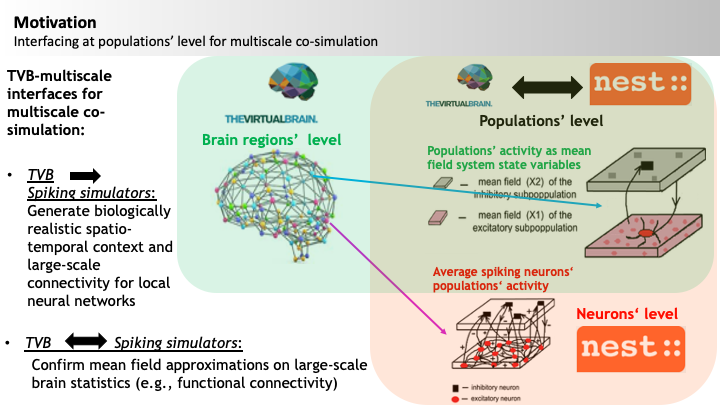

In [2]:
display(Image(filename='./pics/ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

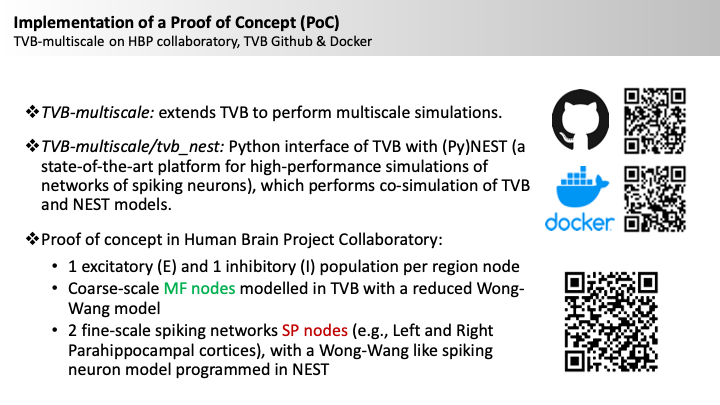

In [3]:
display(Image(filename='./pics/Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Reduced Wong-Wang TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + (1-{S_{n\prime}}(t))\gamma {R_{n\prime}}(t)$

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in NEST as a spiking network:

Membrane 

potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C - g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e$

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

Finally, $ {R_{int_{n}}}(t) $ overwrites the variable ${R_{n}}(t)$ via a user defined transform function:

${R_{n}}(t) = f_{NEST->TVB}({R_{int_{n}}}(t)) $

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

# WORKFLOW:

In [4]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale"
working_path = os.path.join(home_path, "docs/documented_example_notebook")
data_path = os.path.join(home_path, "examples/data")
config = Config(output_base=os.path.join(working_path, "outputs_Izhikevich"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

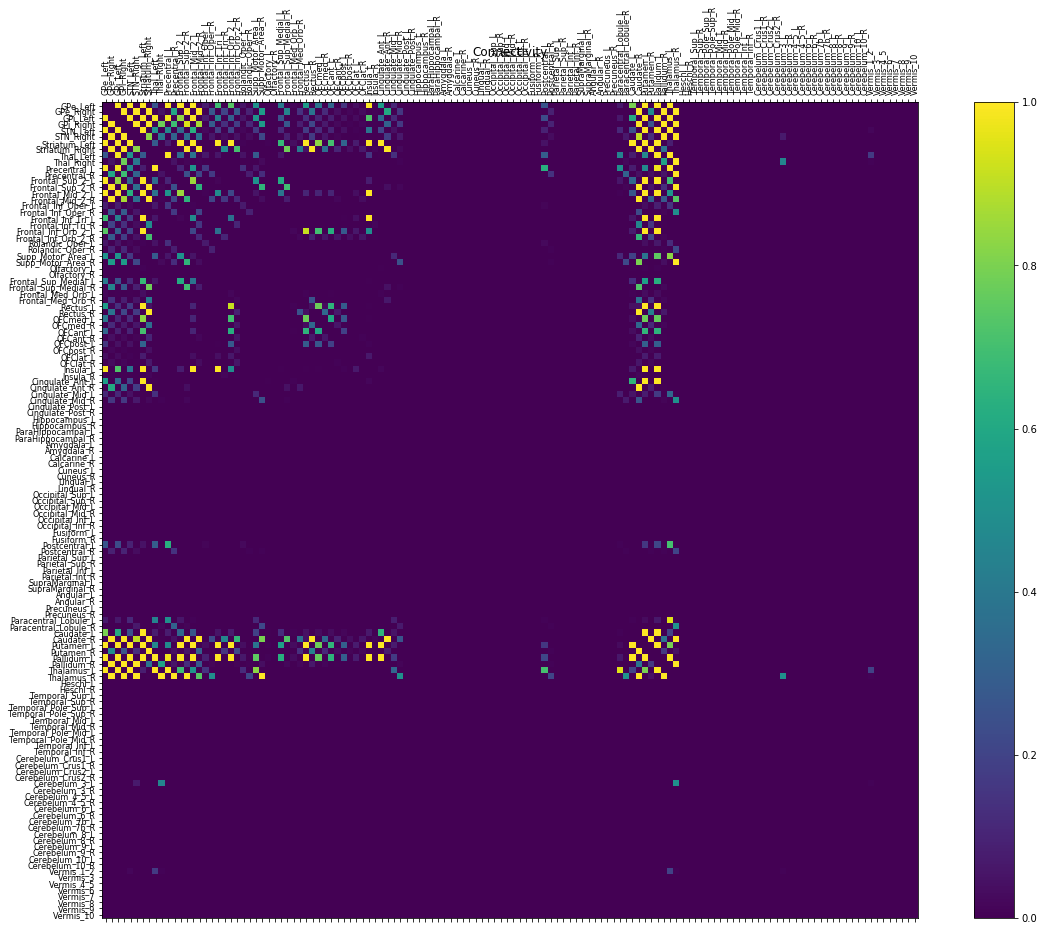

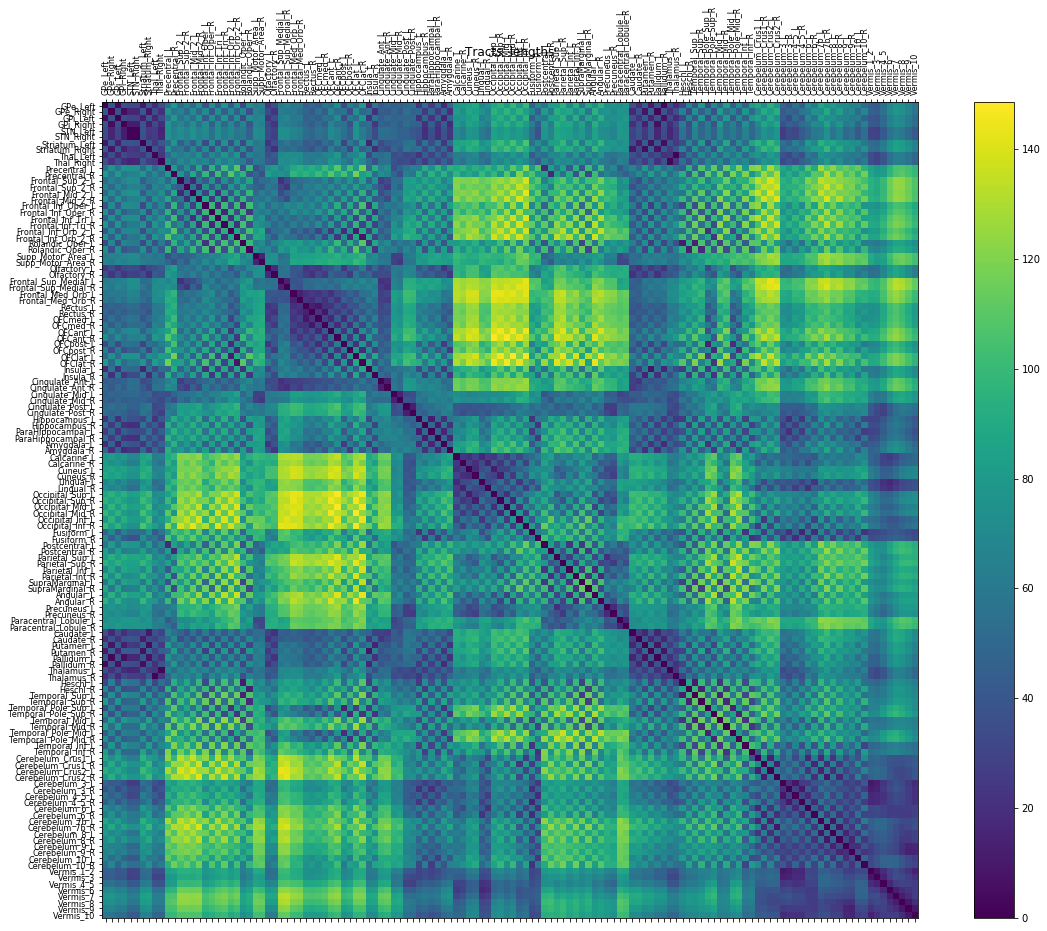

In [5]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG
    
# Load connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
w=np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
c=np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rl= np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
t= np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove BG -> Cortex connections
w[[0, 1, 2, 3, 6, 7], :][:, 10:] = 0.0

connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.configure()
connectivity.speed = np.array([4.0])

#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
model_params = {}
simulator.model = ReducedWongWangExcIO(**model_params)
# simulator.coupling.a = np.array([1.0/256, ])  # Mind the default TVB value!
simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [6]:
try:
    from tvb_multiscale.tvb_nest.nest_models.builders.nest_factory import compile_modules
    compile_modules("izhikevich_hamker", recompile=True, config=config)
except:
    pass

2020-11-27 18:07:31,267 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-11-27 18:07:31,267 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Preparing MYMODULES_BLD_DIR: /home/docker/packages/nest_modules_builds
2020-11-27 18:07:31,283 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/izhikevich_hamker
into /home/docker/packages/nest_modules_builds/izhikevich_hamker...
2020-11-27 18:07:31,283 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Copying module sources from /home/docker/packages/tvb-multiscale/tvb_multiscale/tvb_nest/nest/modules/izhikevich_hamker
into /home/docker/packages/nest_modules_builds/izhikevich_hamker...
2020-11-27 18:07:31,312 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.nest_factory - Compiling izhikev

In [7]:
# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
nest_nodes_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # the indices of fine scale regions modeled with NEST

from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config)



# Using all default parameters for this example


# or...

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200

nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item() 

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "c": -65.0,
     "t_ref": 10.0, "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "C_m": 1.0, "I_e": 0.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_th": 40.0, "C_m": 50.0,
                                     "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

nest_model_builder.Igpe_nodes_ids = [0, 1]
nest_model_builder.Igpi_nodes_ids = [2, 3]
nest_model_builder.Estn_nodes_ids = [4, 5]
nest_model_builder.Eth_nodes_ids = [8, 9]
nest_model_builder.Istr_nodes_ids = [6, 7]
I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [4, 5], Eth in [8, 9]
     "scale": 1.0},
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0, 1], Igpi in [2, 3]
     "scale": 1.0},
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [6, 7]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [6, 7]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0},
]

# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, 'allow_multapses': True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}

# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item()
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
nest_model_builder.global_coupling_scaling *= nest_model_builder.tvb_simulator.model.G[0].item()

within_node_delay = 1.0


nest_model_builder.populations_connections = [
     #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe" and "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight":-1, 
     "delay": within_node_delay,
     "receptor_type": 0, "nodes": I_nodes_ids},  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": -1, 
     "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": -1, 
     "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    ]
    

# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay
        
class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    sign = 1

    def __init__(self, sign=1):
        self.sign = sign
        self.global_coupling_scaling *= self.sign

    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
    #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": ["IdSN", "IiSN"],   # "Eth" -> ["IdSN", "IiSN"]
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe", "Igpi"]
     "synapse_model": synapse_model, "conn_spec": conn_spec,
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": I_nodes_ids},  # None means apply to all
    ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "ascii"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "ascii",
          'record_from': ["V_m", "U_m", "I_syn", "I_syn_ex", "I_syn_in", "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

# Create a spike stimulus input device
# When TVB is connected, we don't need any baseline stimulus
# nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineEstn": ["E"]},  # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
#      "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#      "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
#      "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#      "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
#      "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "ac_generator",
#      "params": {"frequency": 30.0, "phase": 0.0, "amplitude": 1.0, "offset": 0.0,
#                 "start": 1.0},  # "stop": 100.0  "origin": 0.0, 
#      "connections": {"DBS_Estn": ["E"]}, # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,      # "Estn"
#      "weights": 1.0, "delays": 0.0}
    ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()

populations_sizes = []
print("Population sizes: ")
for pop in nest_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))


2020-11-27 18:07:51,663 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-27 18:07:51,663 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-11-27 18:07:51,667 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-27 18:07:51,667 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-11-27 18:07:51,673 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-27 18:07:51,673 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-11-27 18:07:51,681 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-11-27 18:07:51,681 - INFO - tvb_multiscale.t

2020-11-27 18:07:52,013 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-11-27 18:07:52,013 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2020-11-27 18:07:52,045 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2020-11-27 18:07:52,045 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2020-11-27 18:07:53,023 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2020-11-27 18:07:53,023 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2020-11-27 18:07:54,453 - INFO - tvb_multiscale.core.spiking_models.devices - <class '

In [8]:
print(nest_network.print_str(connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['GPe_Left', 'GPe_Right', 'GPi_Left', 'GPi_Right', 'STN_Left', 'STN_Right', 'Striatum_Left', 'Striatum_Right', 'Thal_Left', 'Thal_Right']
Regions' nodes:


----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: GPe_Left
Populations ['I']:

----------------------------------------------------------------------------------------------------

NESTPopulation - Label: I 
model: izhikevich_hamker
200 neurons: 1...200
parameters: {'a': array([0.005]), 'archiver_length': 0, 'b': array([0

## 3. Build the TVB-NEST interface

In [9]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> NEST


# --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
    
tvb_weight_fun = \
    lambda source_node, target_node: \
                 scale_tvb_weight(source_node, target_node, 
                                  tvb_nest_builder.tvb_weights, scale=tvb_nest_builder.global_coupling_scaling)

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

tvb_nest_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_nest_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes in zip([["IdSN", "IiSN"],                  "E"],
                                      [nest_model_builder.Istr_nodes_ids, E_nodes_ids]):
        tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "inhomogeneous_poisson_generator",
             "params": {"allow_offgrid_times": False},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 5.0, # Assuming a connectome of ~120 cortical regions, for a total of ~600 neurons
        # Applied outside NEST for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
             "weights": lambda tvb_node_id, nest_node_id: tvb_weight_fun(tvb_node_id, nest_node_id),
             "delays": lambda tvb_node_id, nest_node_id: tvb_delay_fun(tvb_node_id, nest_node_id),
             "receptor_type": 0,
        # --------------------------------------------------------------------------------------------------------------
        #             TVB sv -> NEST population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- NEST:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, nest_model_builder.Istr_nodes_ids]):
        #            TVB <- NEST
        tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_recorder", "params": {},
        # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    #            TVB <- NEST
    
tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_recorder the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)

2020-11-27 18:08:07,780 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-27 18:08:07,780 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-27 18:08:07,785 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-27 18:08:07,785 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-11-27 18:08:07,818 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-11-27 18:08:07,818 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-11-27 18:08:36,26

2020-11-27 18:09:10,700 - INFO - tvb_multiscale.core.interfaces.spikeNet_to_tvb_interface - <class 'tvb_multiscale.tvb_nest.interfaces.nest_to_tvb_interfaces.NESTtoTVBinterface'> of model  for  created!
2020-11-27 18:09:10,715 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.tvb_nest.interfaces.nest_to_tvb_interfaces.NESTtoTVBinterface'> of model spike_recorder for Rin created!
2020-11-27 18:09:10,715 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.tvb_nest.interfaces.nest_to_tvb_interfaces.NESTtoTVBinterface'> of model spike_recorder for Rin created!


In [10]:
print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface


----------------------------------------------------------------------------------------------------


TVB to spikeNet interfaces:

----------------------------------------------------------------------------------------------------

Index: 0_R->['IdSN', 'IiSN']

TVBtoNESTInhomogeneousPoissonGeneratorInterface
Name: R, TVB state variable indice: 2, 
Interface weights: [5.0]
Target NEST Nodes indices:
10...129 
TVBtoNESTInhomogeneousPoissonGeneratorInterface - Name: R, Model: inhomogeneous_poisson_generator,
Devices:
----------------------------------------------------------------------------------------------------

R_Precentral_L: NESTInhomogeneousPoiss

## 4. Configure simulator, simulate, gather results

In [11]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length=110.0
transient = 10.0 # simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))


Simulated in 332.044634 secs!


In [12]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [13]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [14]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts

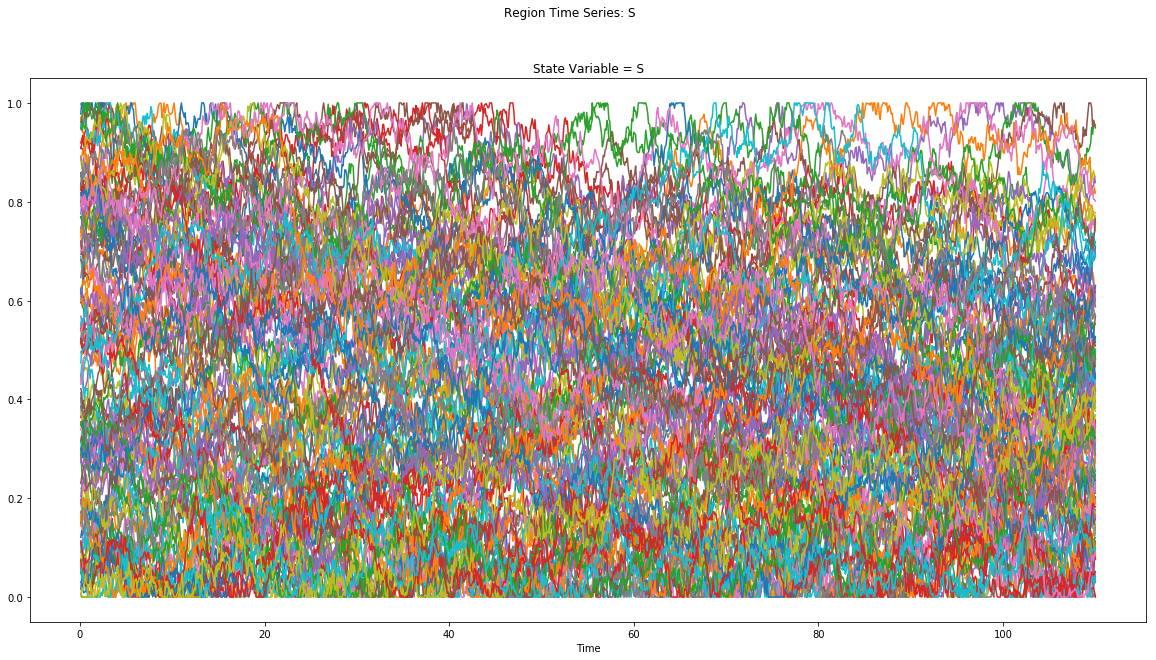

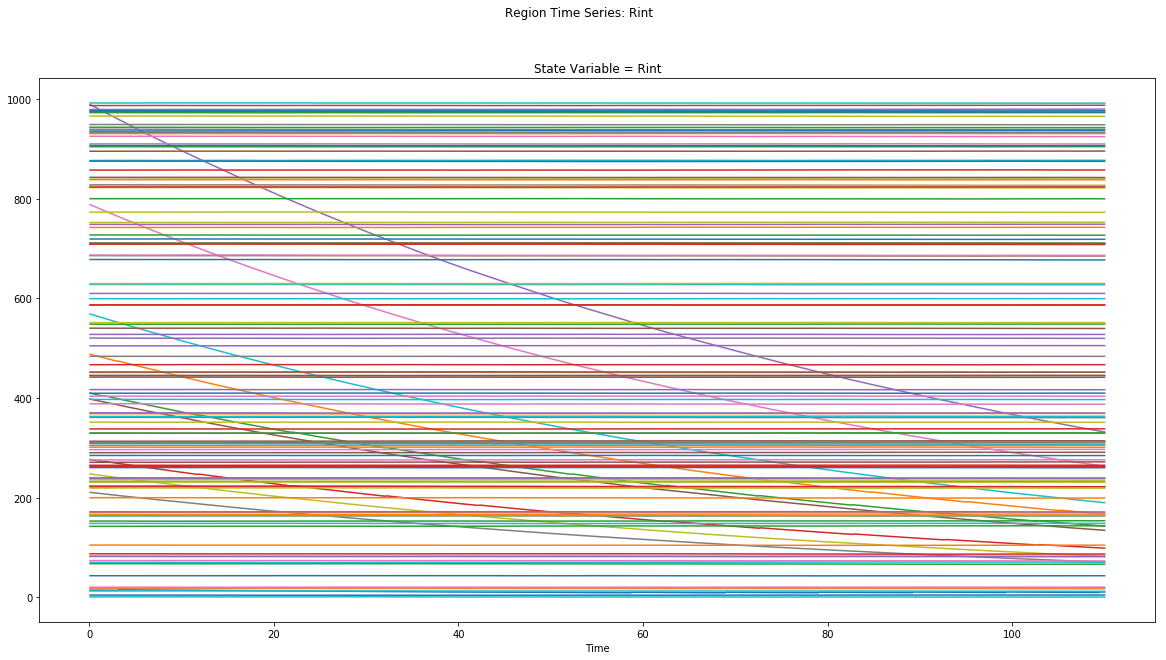

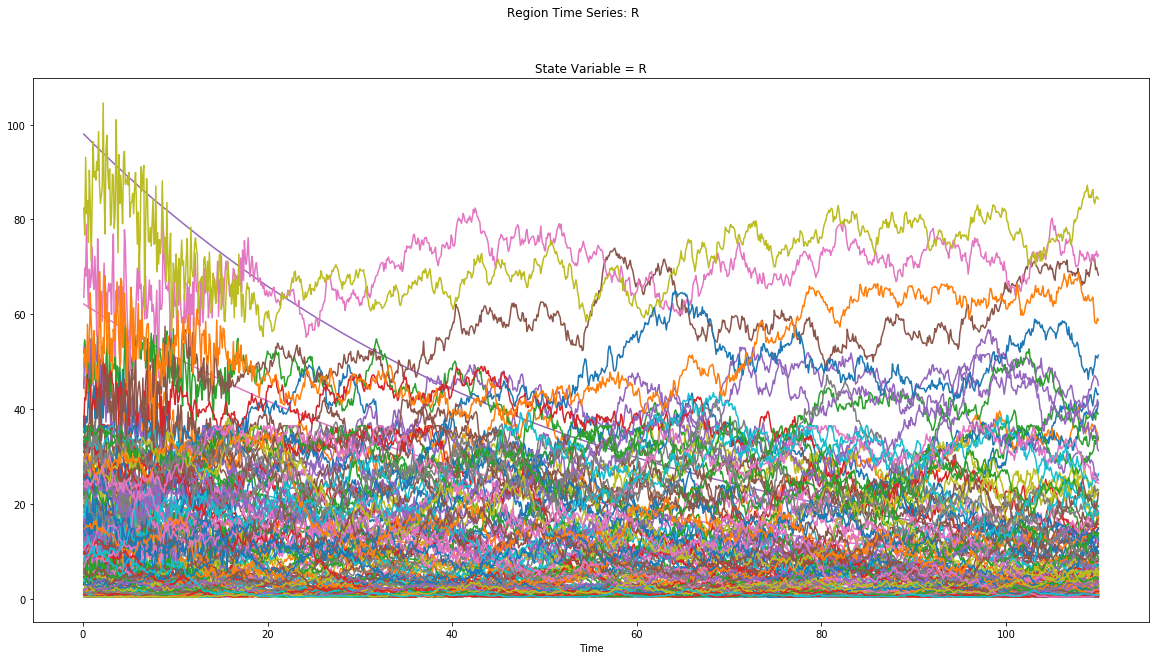

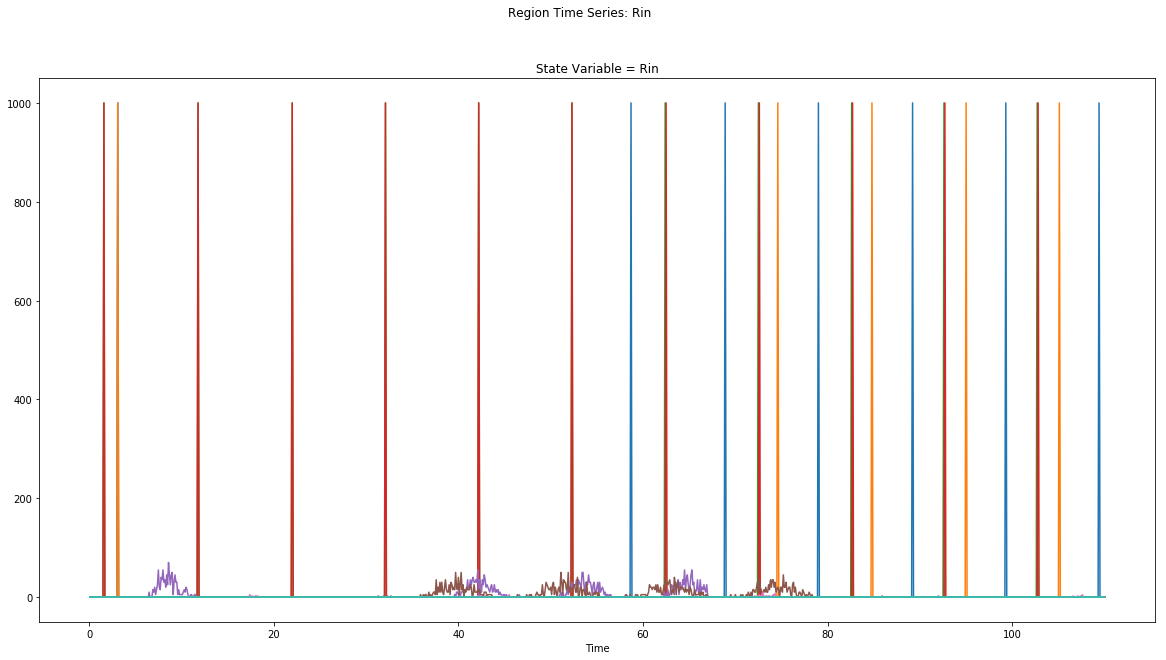

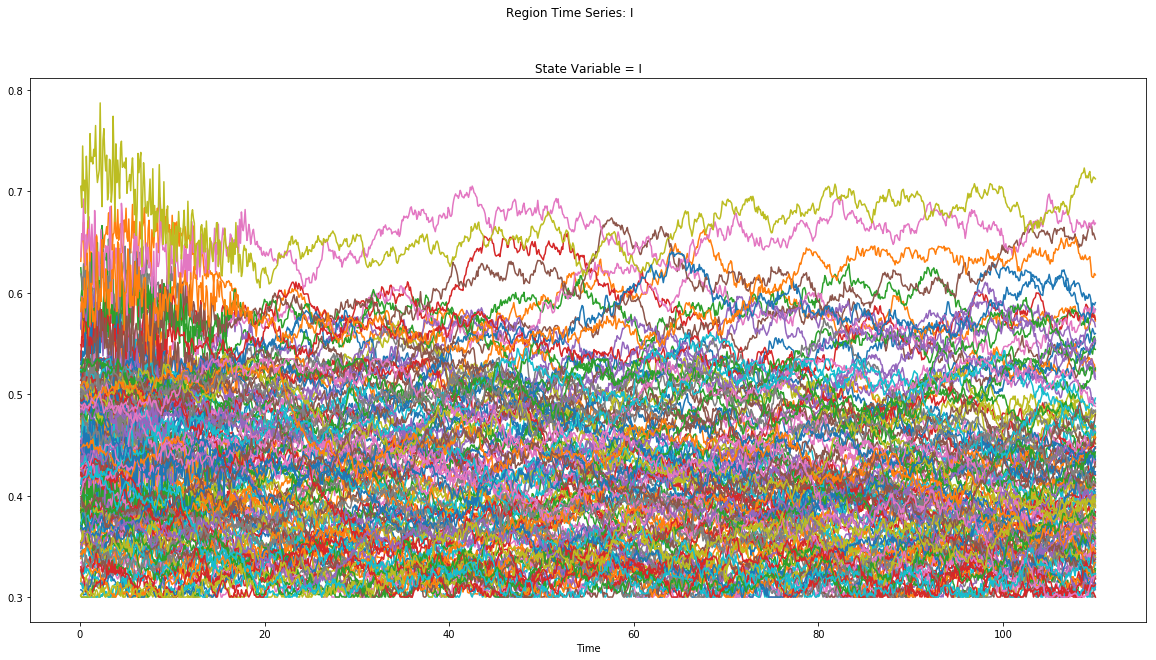

In [15]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

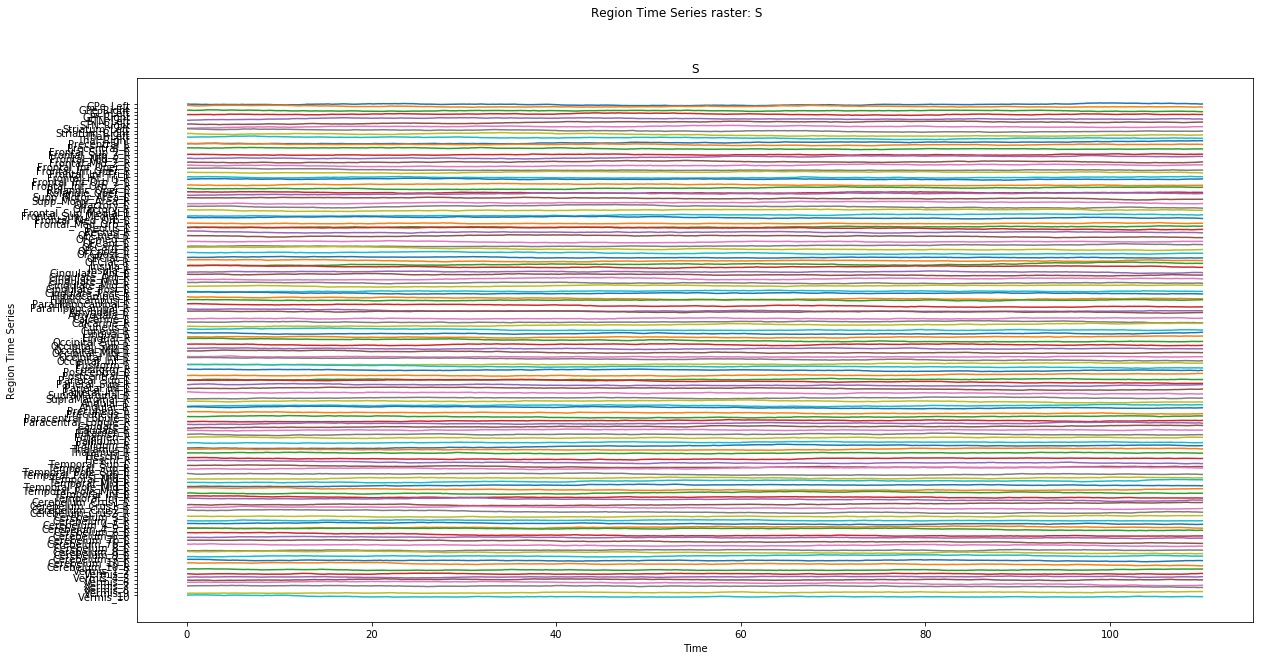

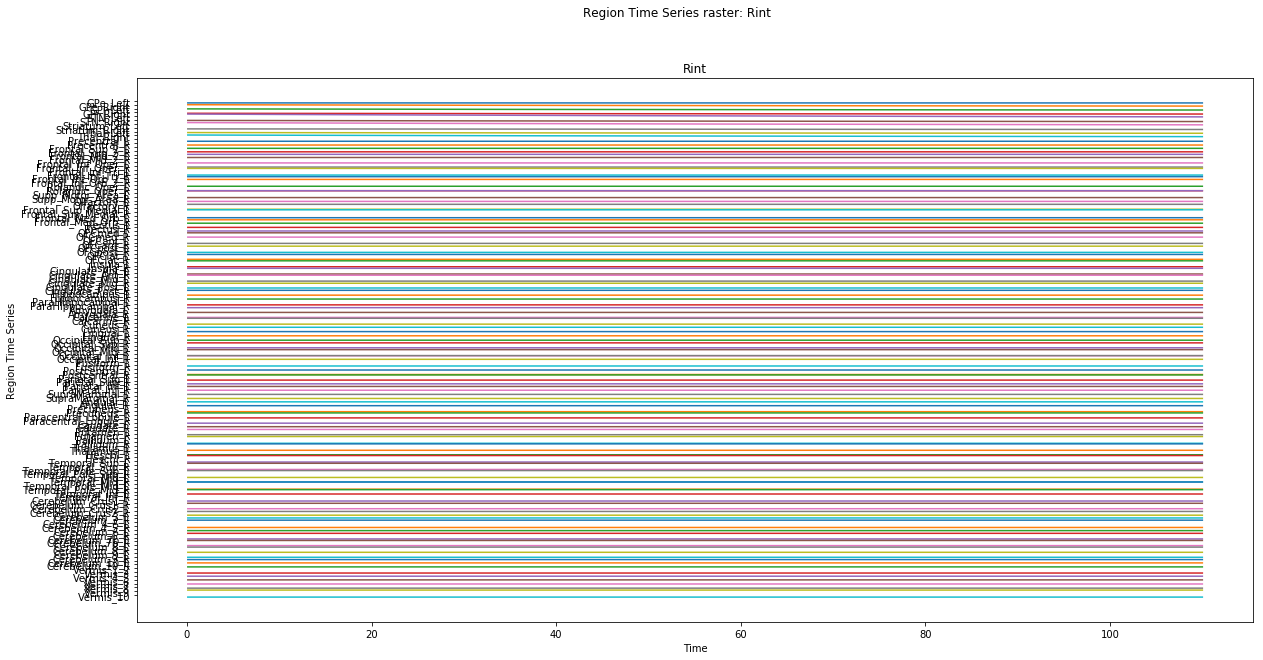

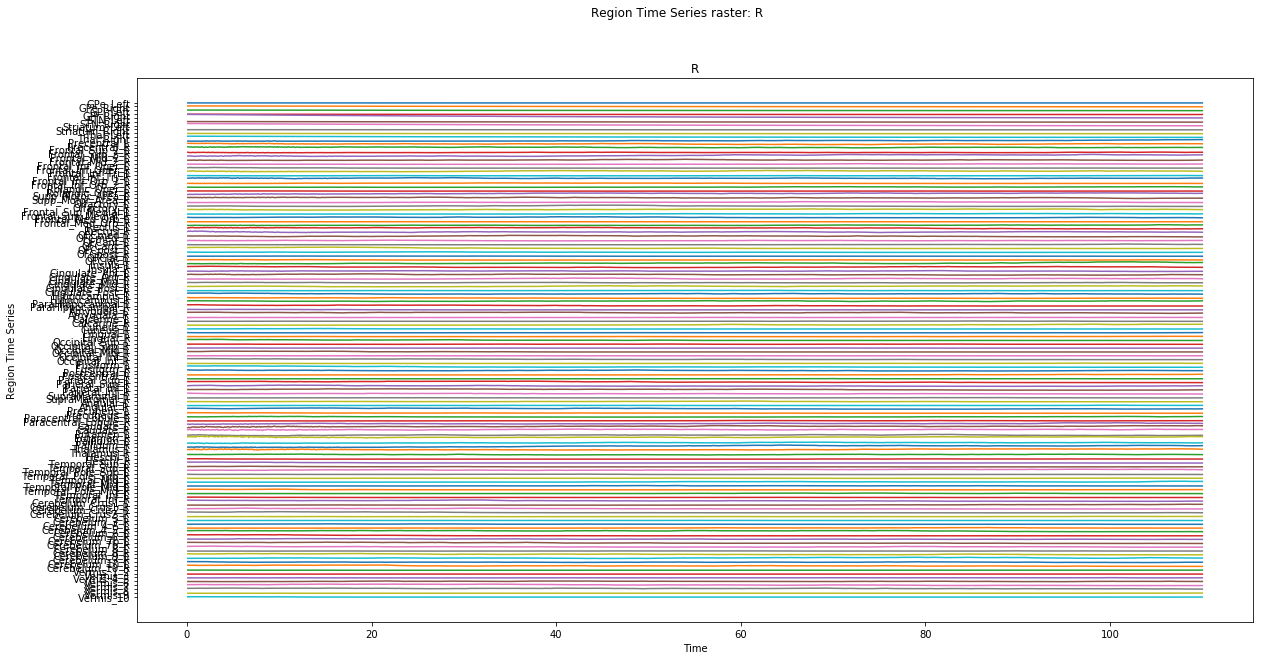

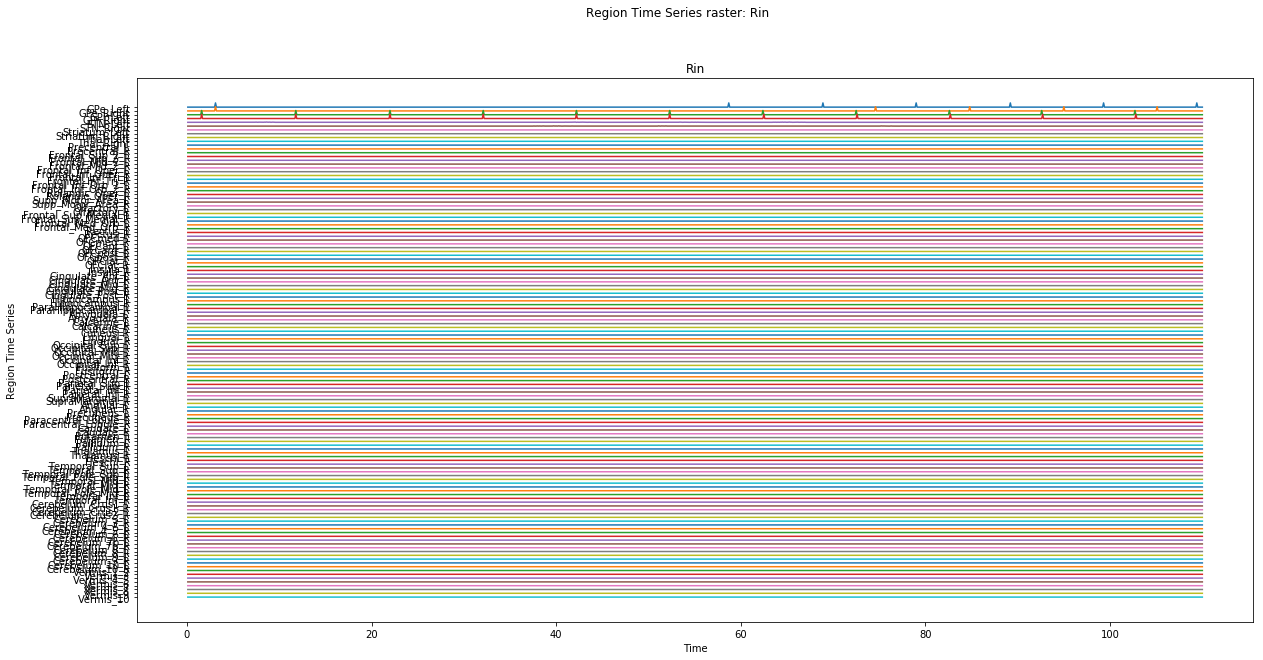

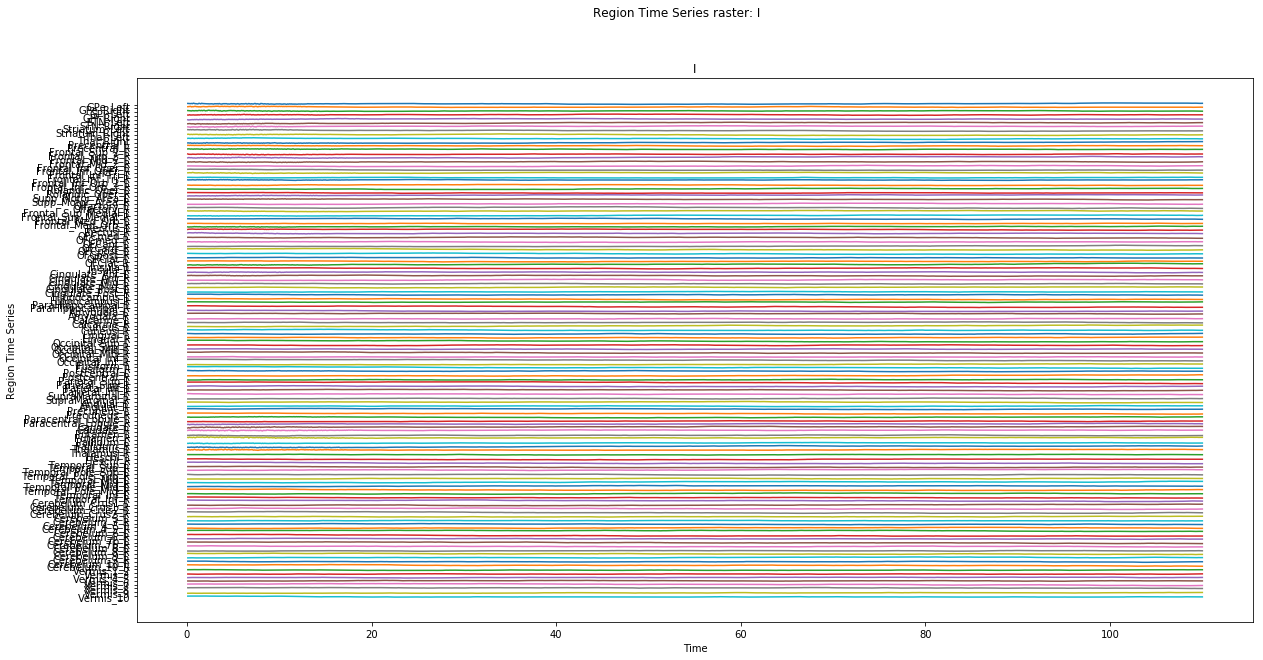

In [16]:
# TVB time series raster plot:
if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts.plot_raster(plotter_config=plotter.config, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
                          figsize=FIGSIZE);

2020-11-27 18:15:15,748 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:15,766 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:17,327 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:18,219 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:19,336 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:20,274 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


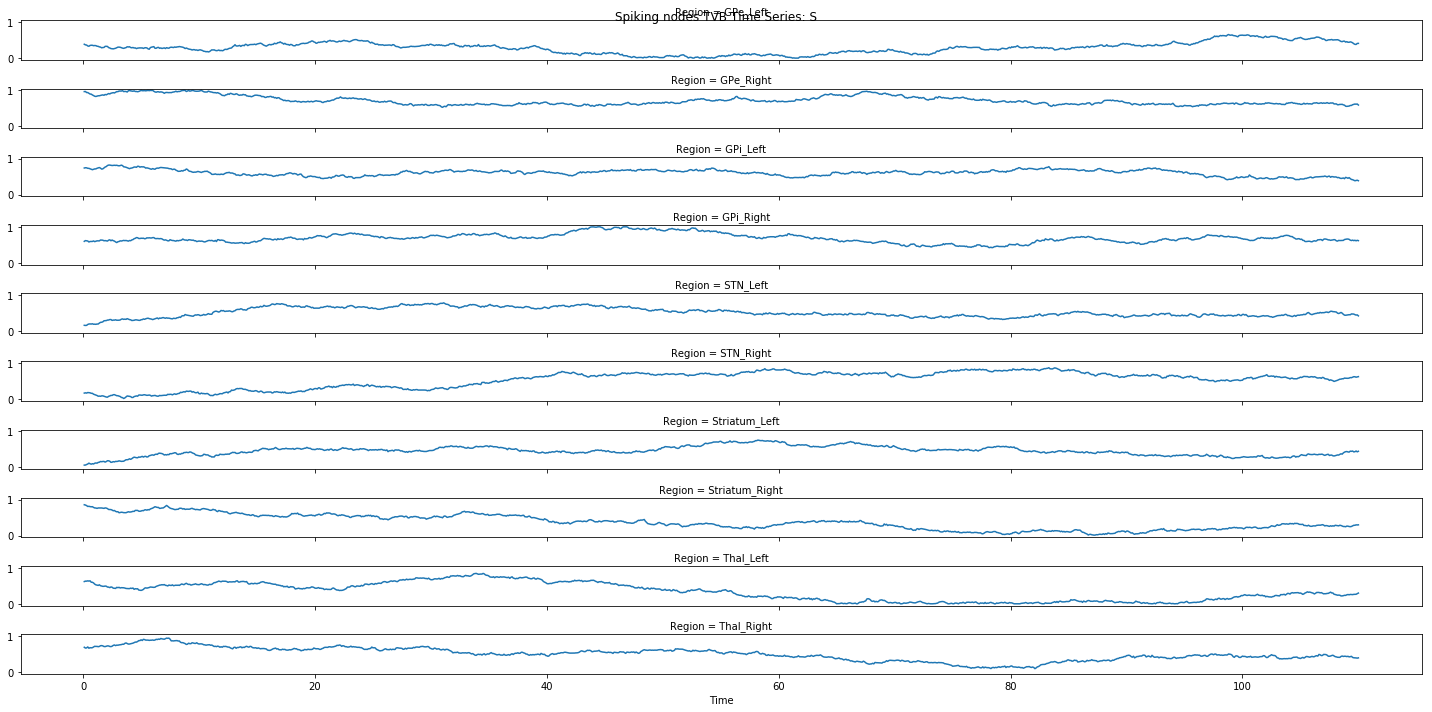

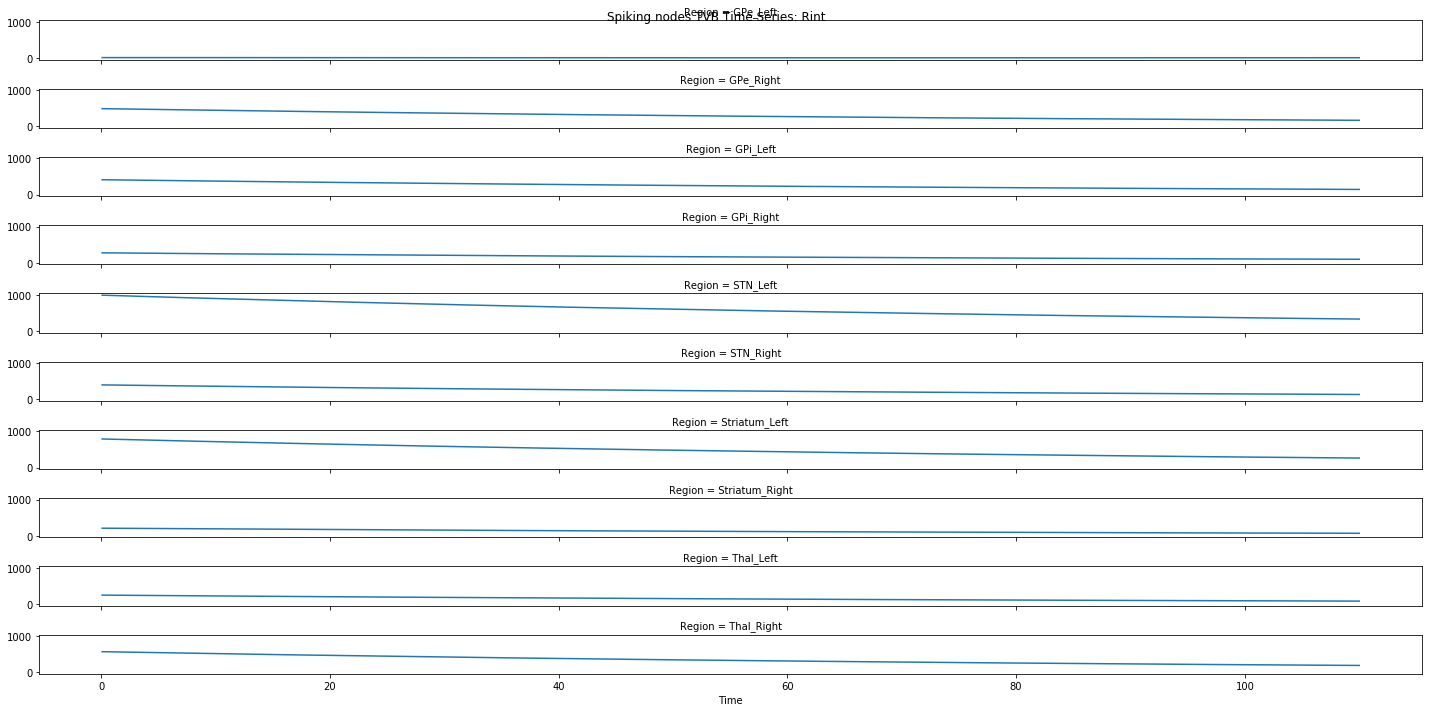

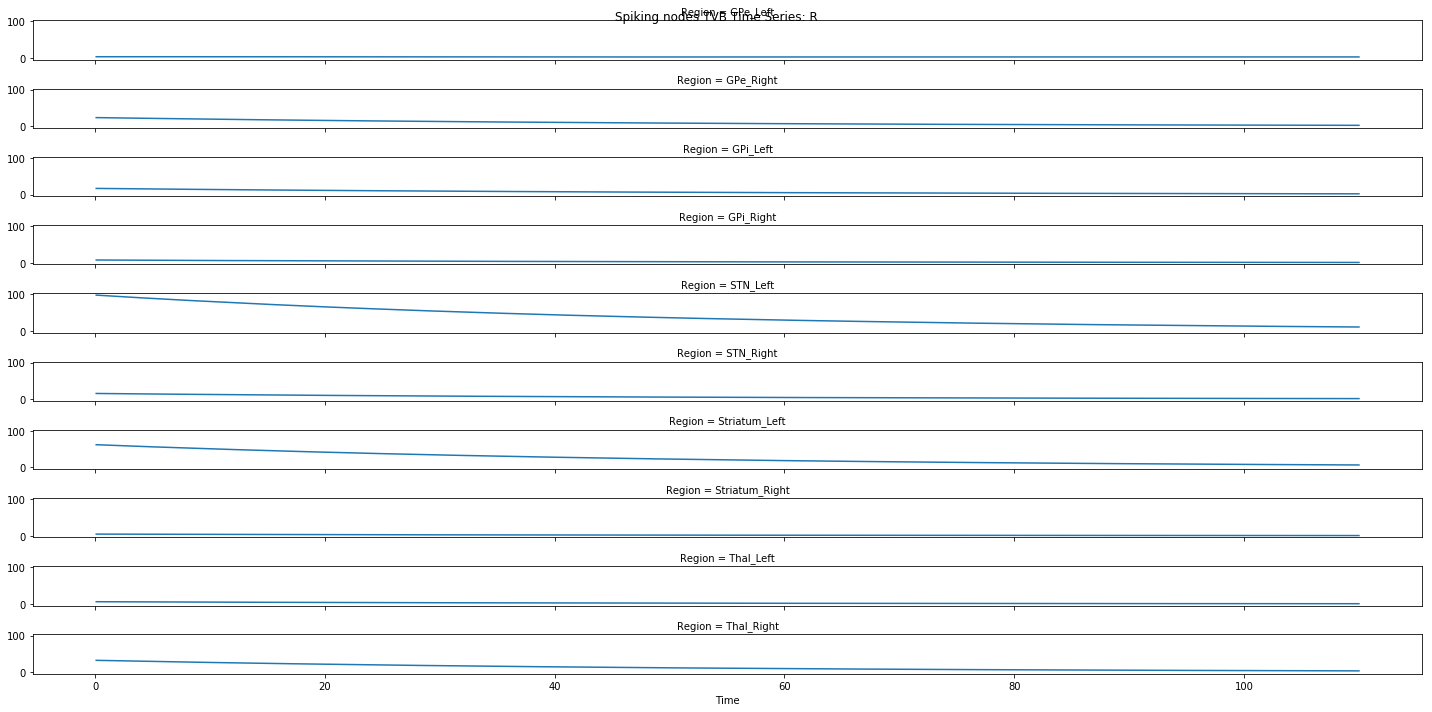

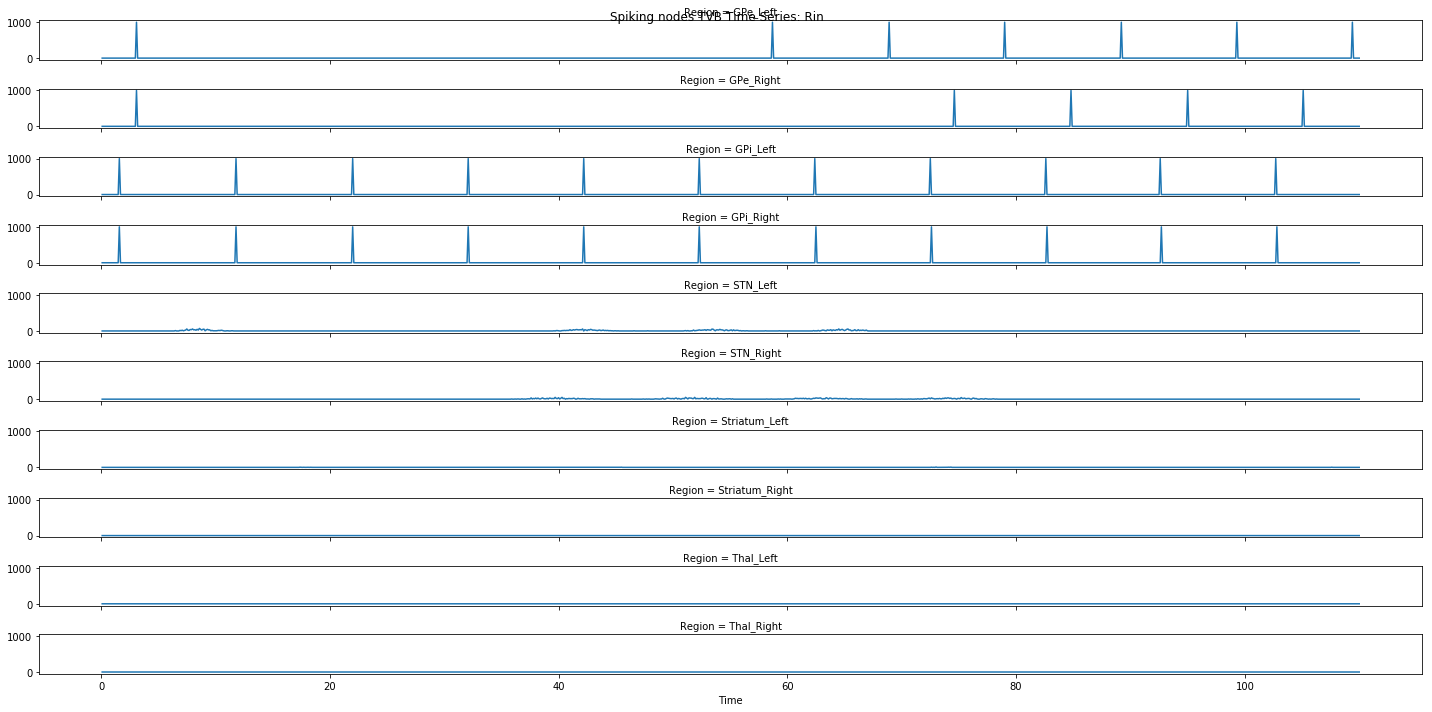

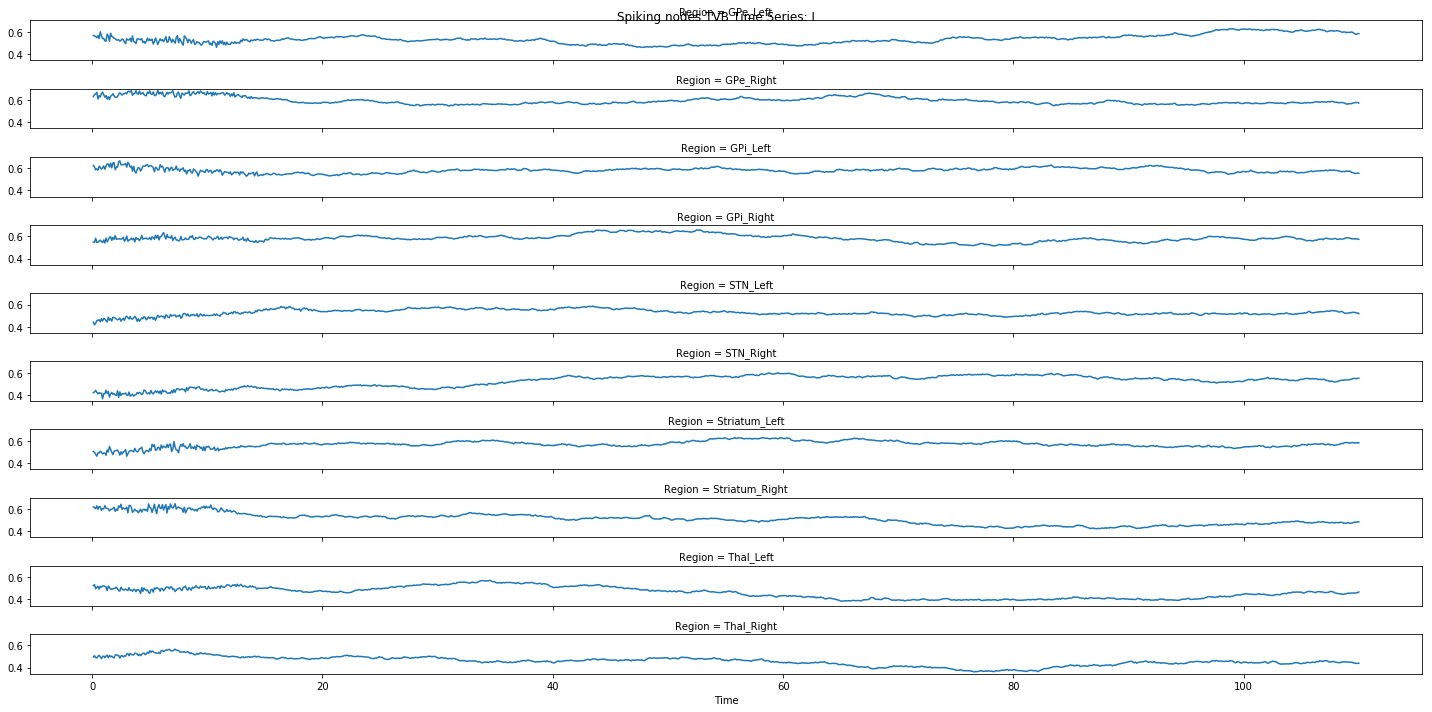

In [17]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

2020-11-27 18:15:27,082 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:27,523 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:27,888 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:28,180 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:28,533 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


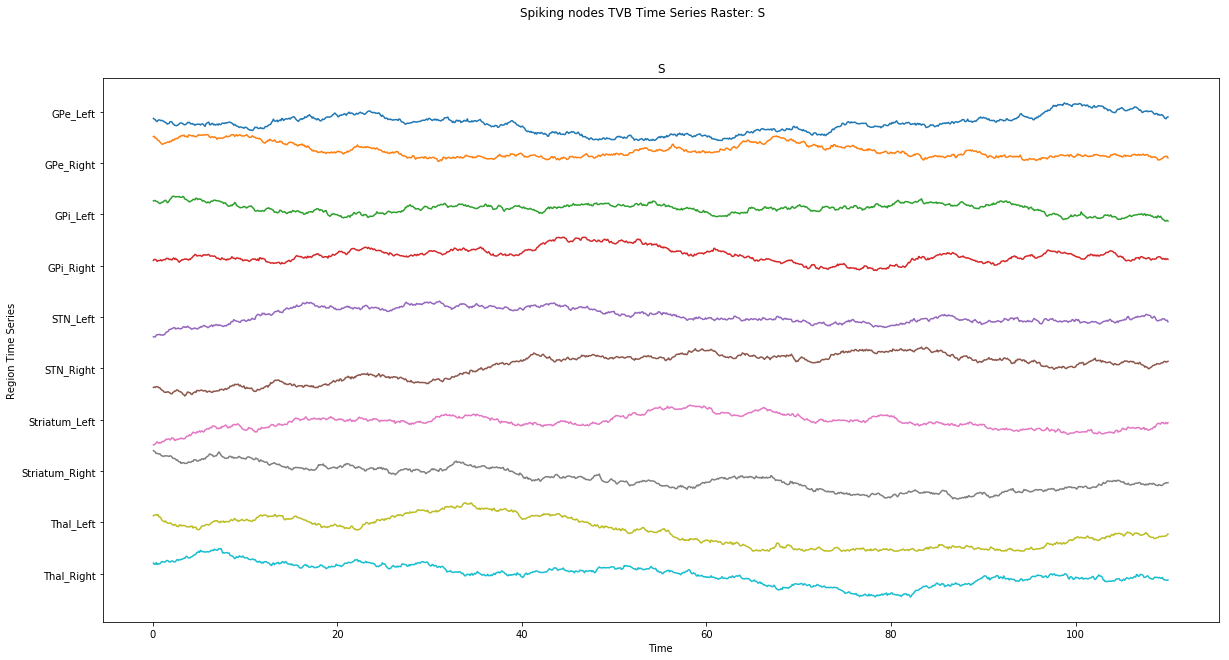

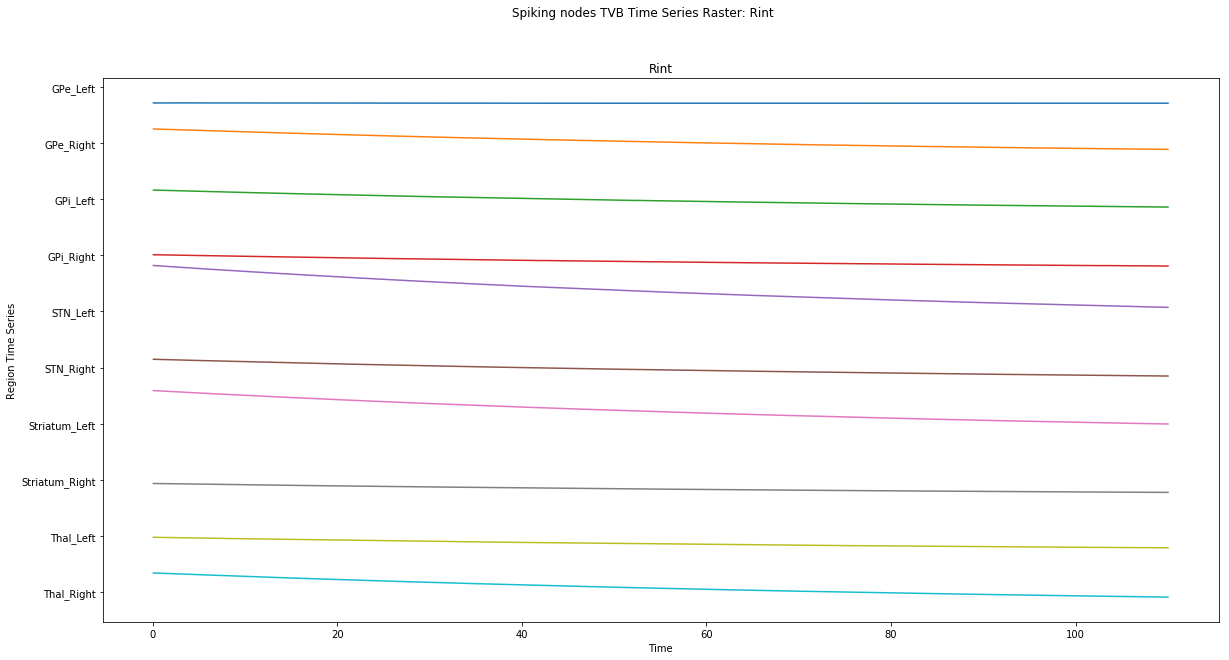

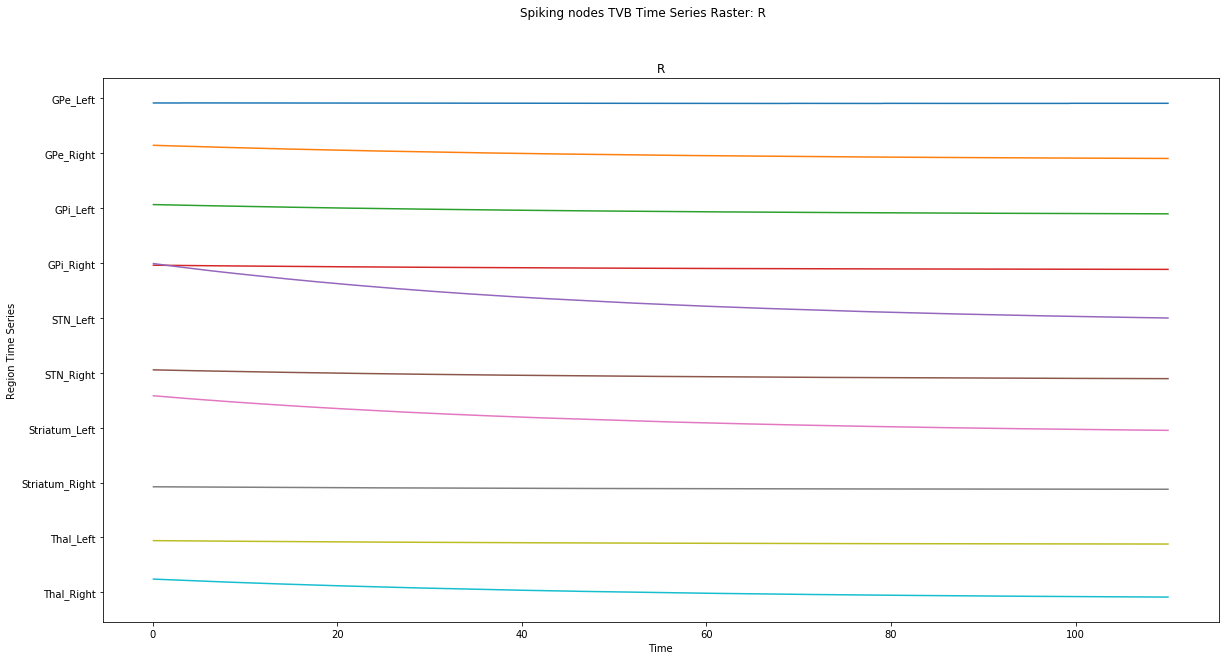

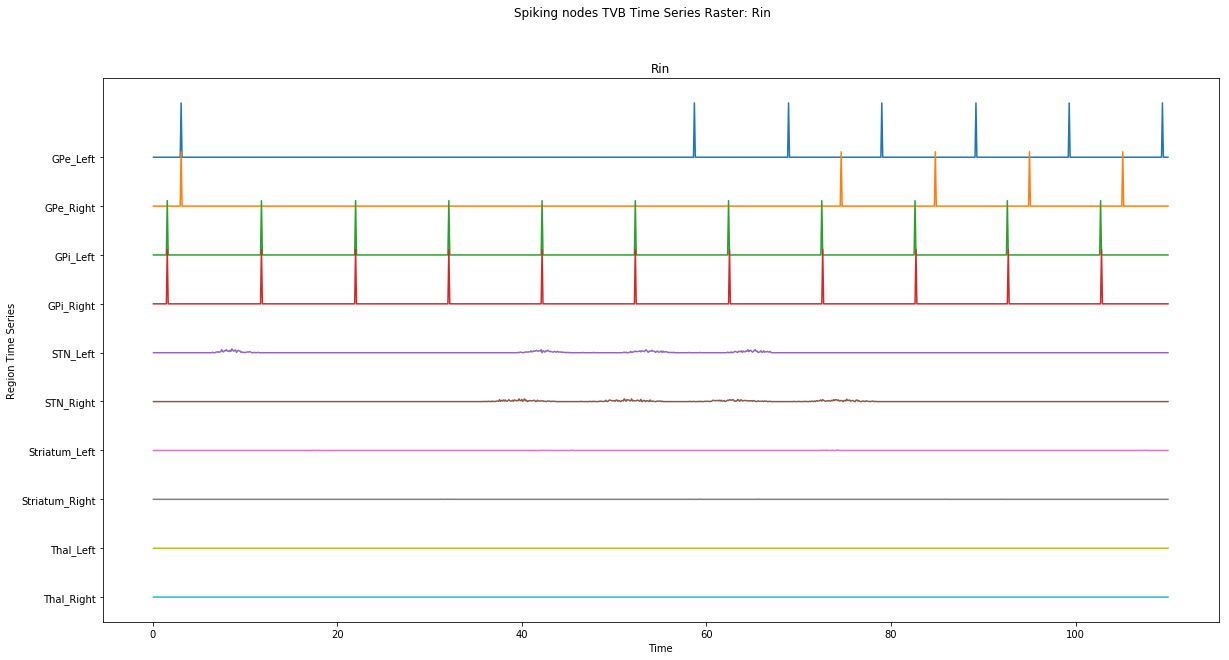

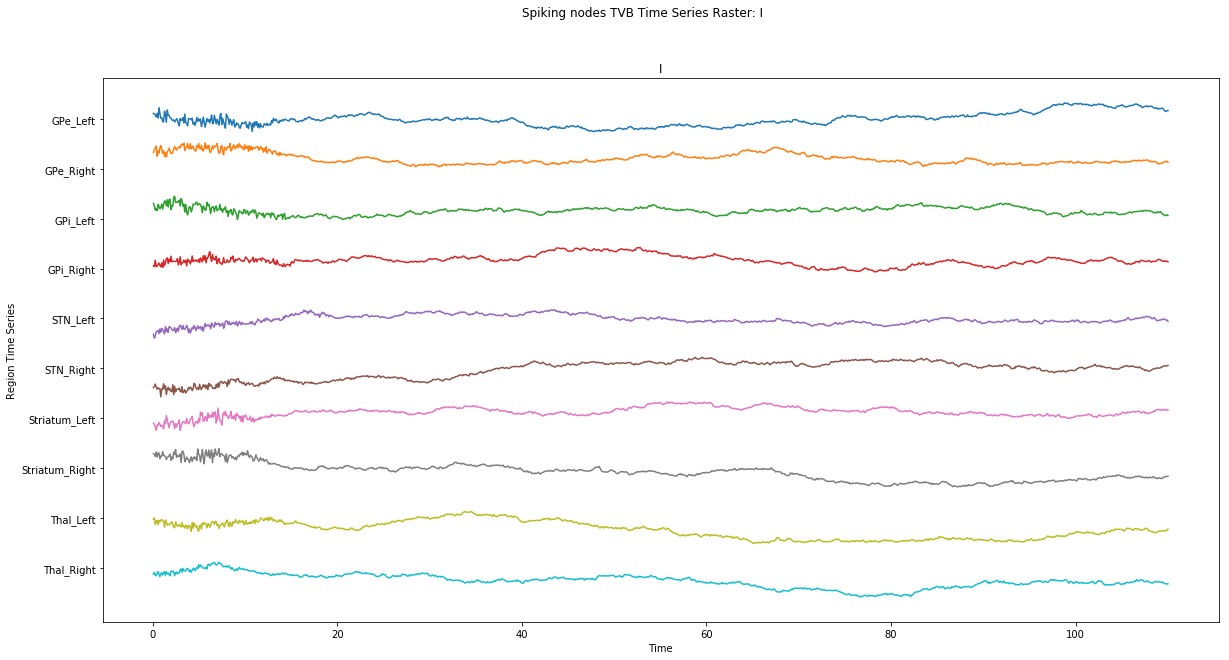

In [18]:
# Focus on the nodes modelled in NEST: raster plot
if source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
    source_ts_nest.plot_raster(plotter_config=plotter.config, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [19]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

### Spiking Network plots

In [20]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=source_ts.time[0], end_time=source_ts.time[-1], 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [21]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 65 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 56 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 200 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:990: UserWarning:Correcting 400 rounding errors by shifting the affected spikes into the following bin. You can set tolerance=None to disable this behaviour.
/home/docker/env/neurosci/lib/python3.7/site-packages/elephant

<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 10)>
array([[       nan,        nan,        nan,        nan, 0.03063063,
        0.03993994,        nan,        nan, 0.        , 0.        ],
       [0.06006006, 0.04004004, 0.1001001 , 0.1001001 ,        nan,
               nan,        nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.0011011 , 0.00025025,        nan,        nan],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.001001  , 0.00025025,        nan,        nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPe_Right' ... 'Thal_Right'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 10, Region_j: 10)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, na

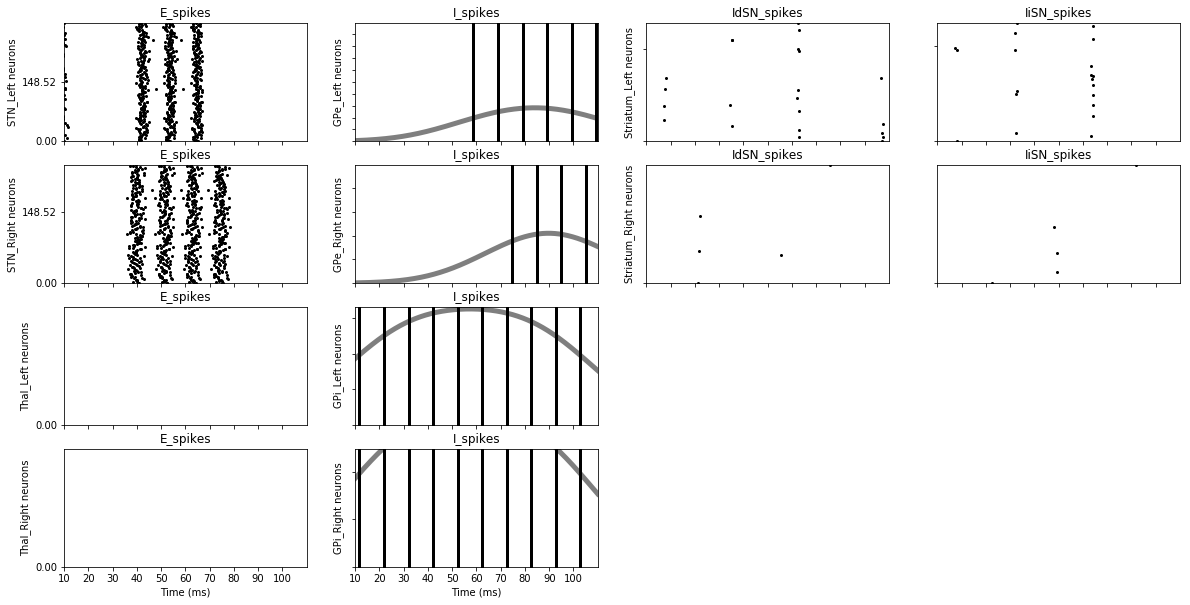

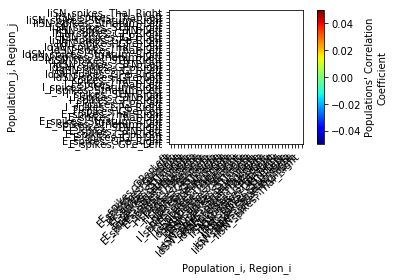

In [22]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], figsize=FIGSIZE)
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [23]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2020-11-27 18:15:39,497 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Izhikevich/res/Spikes.h5
2020-11-27 18:15:39,497 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Izhikevich/res/Spikes.h5
2020-11-27 18:15:39,538 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,538 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,551 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,551 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,601 - WARNING - tvb_

2020-11-27 18:15:39,640 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[ 930.  931.  941.  835.  998.  809.  960.  804.  865.  965.  884.  988.
  860.  919.  888.  896.  904.  986.  999.  838.  831.  909.  995.  829.
  869.  877.  928.  978.  898.  997.  933.  922.  893.  902.  850.  834.
  819.  937.  906.  920.  812.  830.  955.  977.  899.  901.  808.  810.
  857.  912.  953.  863.  916.  846.  859.  875.  876.  939.  940.  984.
  805.  861.  827.  924.  815.  868.  820.  886.  951.  958.  855.  874.
  972.  840.  862.  849.  967.  853.  897.  929.  987.  854.  894.  870.
  881.  907.  945.  981.  837.  971.  918.  970.  979.  992.  885.  871.
  813.  814.  867.  936.  823.  833.  836.  911.  915.  954.  996.  807.
  969.  826.  883.  952.  956.  843.  917.  985.  817.  968.  816.  982.
  950.  821.  976.  866.  926.  935.  824.  989.  822.  908.  852.  882.
  927.  957.  872. 

2020-11-27 18:15:39,649 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,649 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,659 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,659 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,696 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Right" (2 members)> dataset <class 'numpy.ndarray'> times:
[35.875 36.125 36.375 36.5   36.725 36.75  36.925 37.15  37.3   37.3
 37.325 37.375 37.5   37.55  37.575 37.575 37.575 37.575 37.6   37.6
 37.625 37.725 37.775 37.8   37.8   37.825 37.9   37.925 37.925 37.95
 37.95  37.95  37.975 38.075 38.075 38.125 38.15  3

2020-11-27 18:15:39,730 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Right" (2 members)> dataset <class 'numpy.ndarray'> senders:
[1084. 1144. 1025. 1049. 1060. 1044. 1064. 1087. 1031. 1085. 1199. 1016.
 1039. 1131. 1014. 1017. 1107. 1132. 1102. 1125. 1106. 1047. 1173. 1011.
 1112. 1179. 1090. 1037. 1136. 1029. 1151. 1175. 1104. 1013. 1188. 1157.
 1098. 1143. 1150. 1182. 1186. 1113. 1066. 1028. 1061. 1053. 1041. 1146.
 1166. 1198. 1161. 1045. 1088. 1121. 1181. 1003. 1142. 1026. 1099. 1035.
 1051. 1122. 1065. 1009. 1022. 1063. 1119. 1115. 1018. 1050. 1114. 1176.
 1012. 1072. 1153. 1024. 1167. 1191. 1042. 1092. 1100. 1189. 1077. 1147.
 1171. 1149. 1006. 1052. 1054. 1023. 1093. 1033. 1083. 1101. 1124. 1055.
 1123. 1056. 1105. 1200. 1140. 1162. 1197. 1148. 1159. 1067. 1048. 1094.
 1154. 1180. 1190. 1004. 1070. 1177. 1134. 1040. 1137. 1169. 1170. 1021.
 1117. 1005. 1032. 1079. 1133. 1178. 1185. 1007. 1057. 1073. 1192. 1130.
 1135. 1138. 1001.

2020-11-27 18:15:39,737 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,737 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,744 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,744 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,751 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[] !

2020-11-27 18:15:39,751 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/Thal_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[] !

2020-11-27 18:15:39,756 - WARNING - tvb_multiscale.core.io.h5_writer -

2020-11-27 18:15:39,873 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPe_Right" (2 members)> dataset <class 'numpy.ndarray'> times:
[  3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075   3.075
   3.075   3.075   3

2020-11-27 18:15:39,909 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPe_Right" (2 members)> dataset <class 'numpy.ndarray'> senders:
[201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212. 213. 214.
 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226. 227. 228.
 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242.
 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255. 256.
 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267. 268. 269. 270.
 271. 272. 273. 274. 275. 276. 277. 278. 279. 280. 281. 282. 283. 284.
 285. 286. 287. 288. 289. 290. 291. 292. 293. 294. 295. 296. 297. 298.
 299. 300. 301. 302. 303. 304. 305. 306. 307. 308. 309. 310. 311. 312.
 313. 314. 315. 316. 317. 318. 319. 320. 321. 322. 323. 324. 325. 326.
 327. 328. 329. 330. 331. 332. 333. 334. 335. 336. 337. 338. 339. 340.
 341. 342. 343. 344. 345. 346. 347. 348. 349. 350. 351. 352. 353. 354.
 355. 356. 357. 358. 359. 360. 361. 362.

2020-11-27 18:15:39,915 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,915 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:39,922 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,922 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:39,930 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[  1.575   1.575   1.575 ... 102.675 102.675 102.675] !

2020-11-27 18:15:39,930 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/I_spikes/GPi_Left" (2 members)> dataset <class 'numpy.ndarray'> times:
[  1.575   1.575   1.575 ..

2020-11-27 18:15:40,074 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> times to h5 file as a numpy array dataset !

2020-11-27 18:15:40,080 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:40,080 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> senders to h5 file as a numpy array dataset !

2020-11-27 18:15:40,090 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Right" (2 members)> dataset <class 'numpy.ndarray'> times:
[32.625 58.25  59.125 59.225 91.925] !

2020-11-27 18:15:40,090 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_Right" (2 members)> dataset <class 'numpy.ndarray'> times:
[32.625 58.25  59.125 59.225 91.925] !

2020-11-27 18:15:40,101 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/IiSN_spikes/Striatum_

2020-11-27 18:15:40,579 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-27 18:15:40,579 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-27 18:15:40,587 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2020-11-27 18:15:40,587 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2020-11-27 18:15:40,607 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population_i' 'Population_j' 'Region_i' 'Region_j'] !

2020-11-27 18:15:40,607 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:

2020-11-27 18:15:40,684 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-11-27 18:15:40,690 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2020-11-27 18:15:40,690 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2020-11-27 18:15:40,699 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2020-11-27 18:15:40,699 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> dims:
['Population_i'] !

2020-11-27 18:15:40,708 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> data:
['E_spikes'

### Get  SpikingNetwork mean field variable time series and plot them

2020-11-27 18:15:53,180 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:54,387 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:55,679 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:56,995 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:58,435 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:15:59,811 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-11-27 18:16:01,097 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

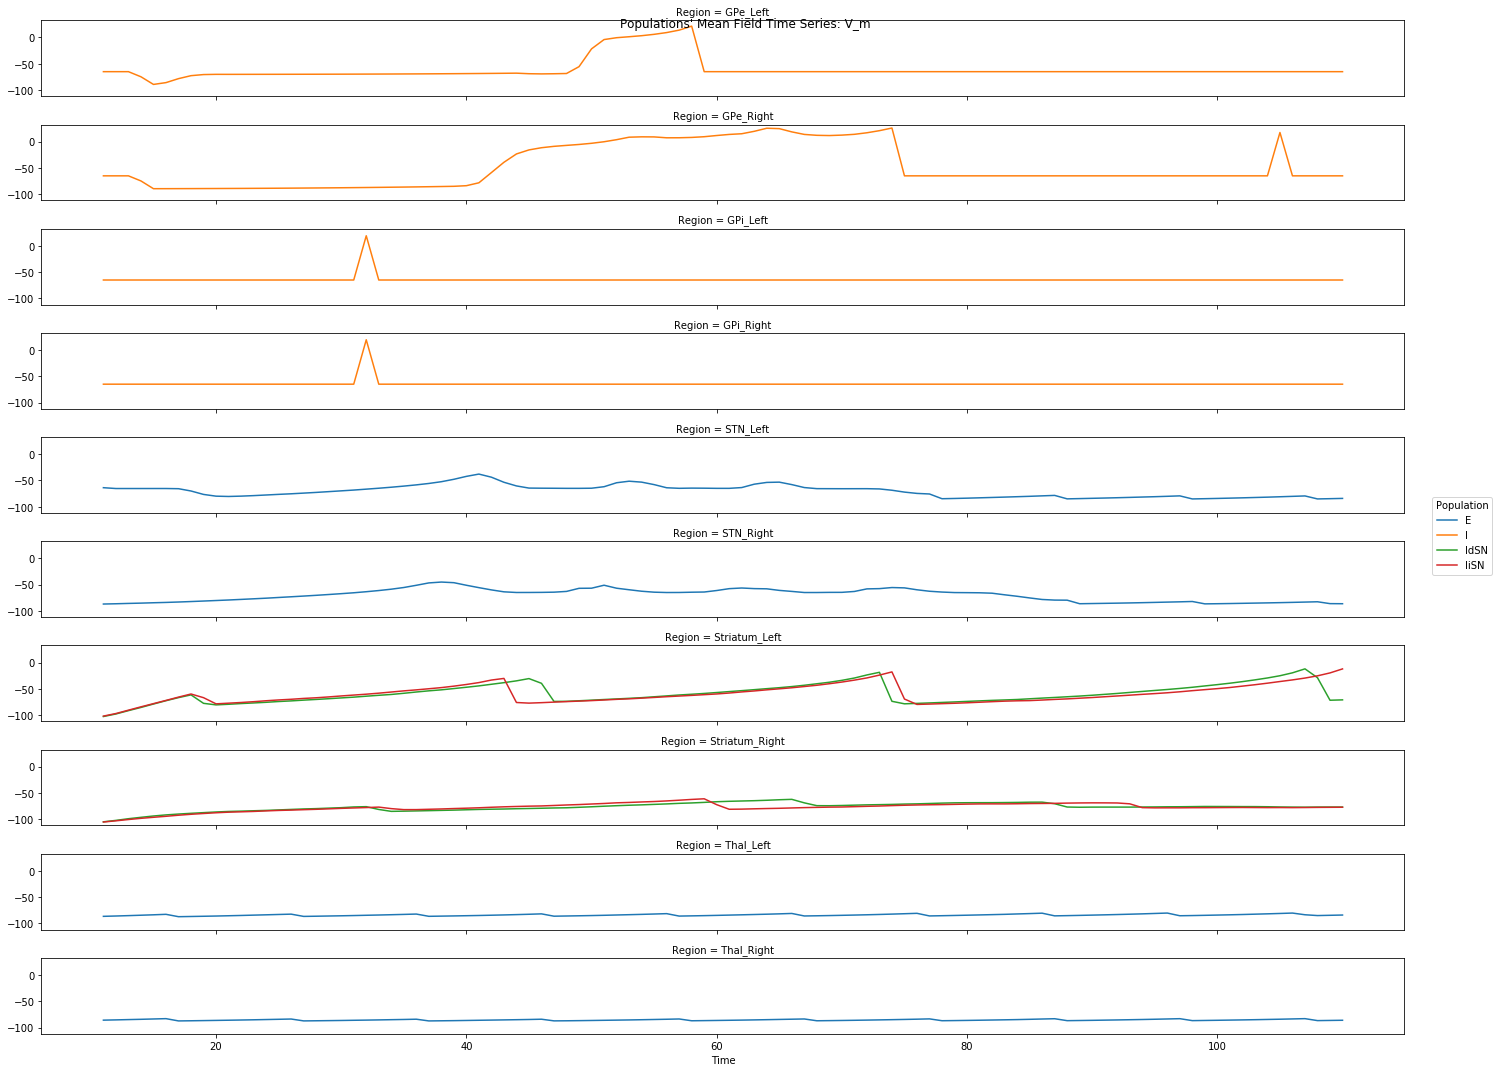

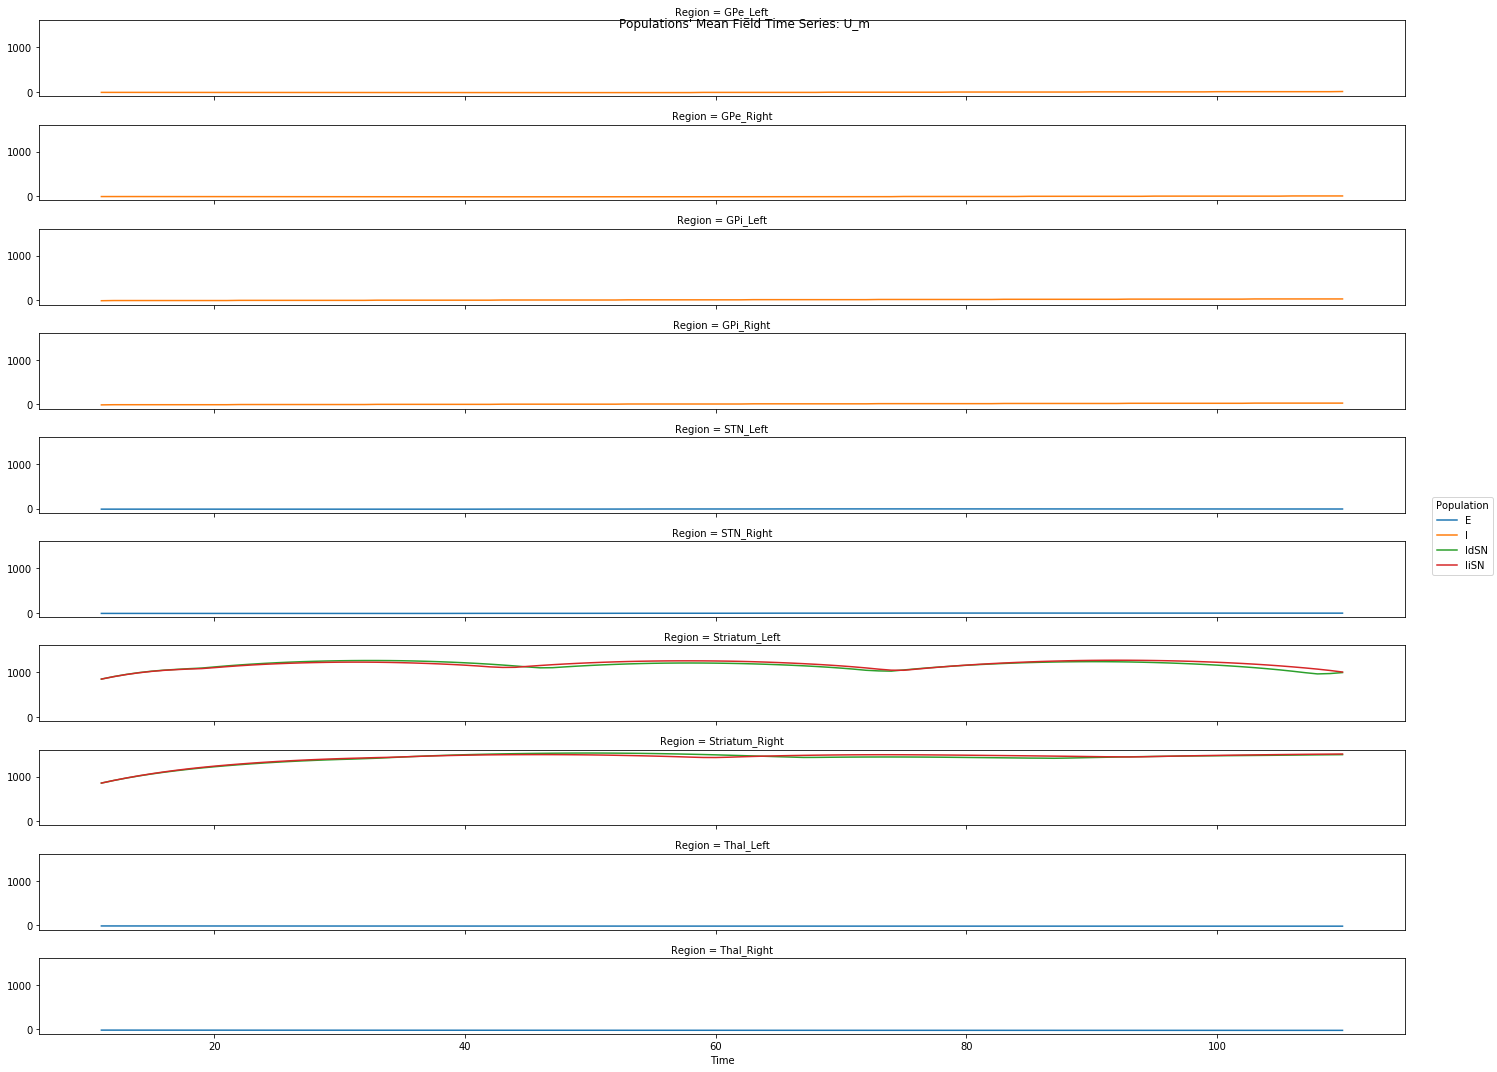

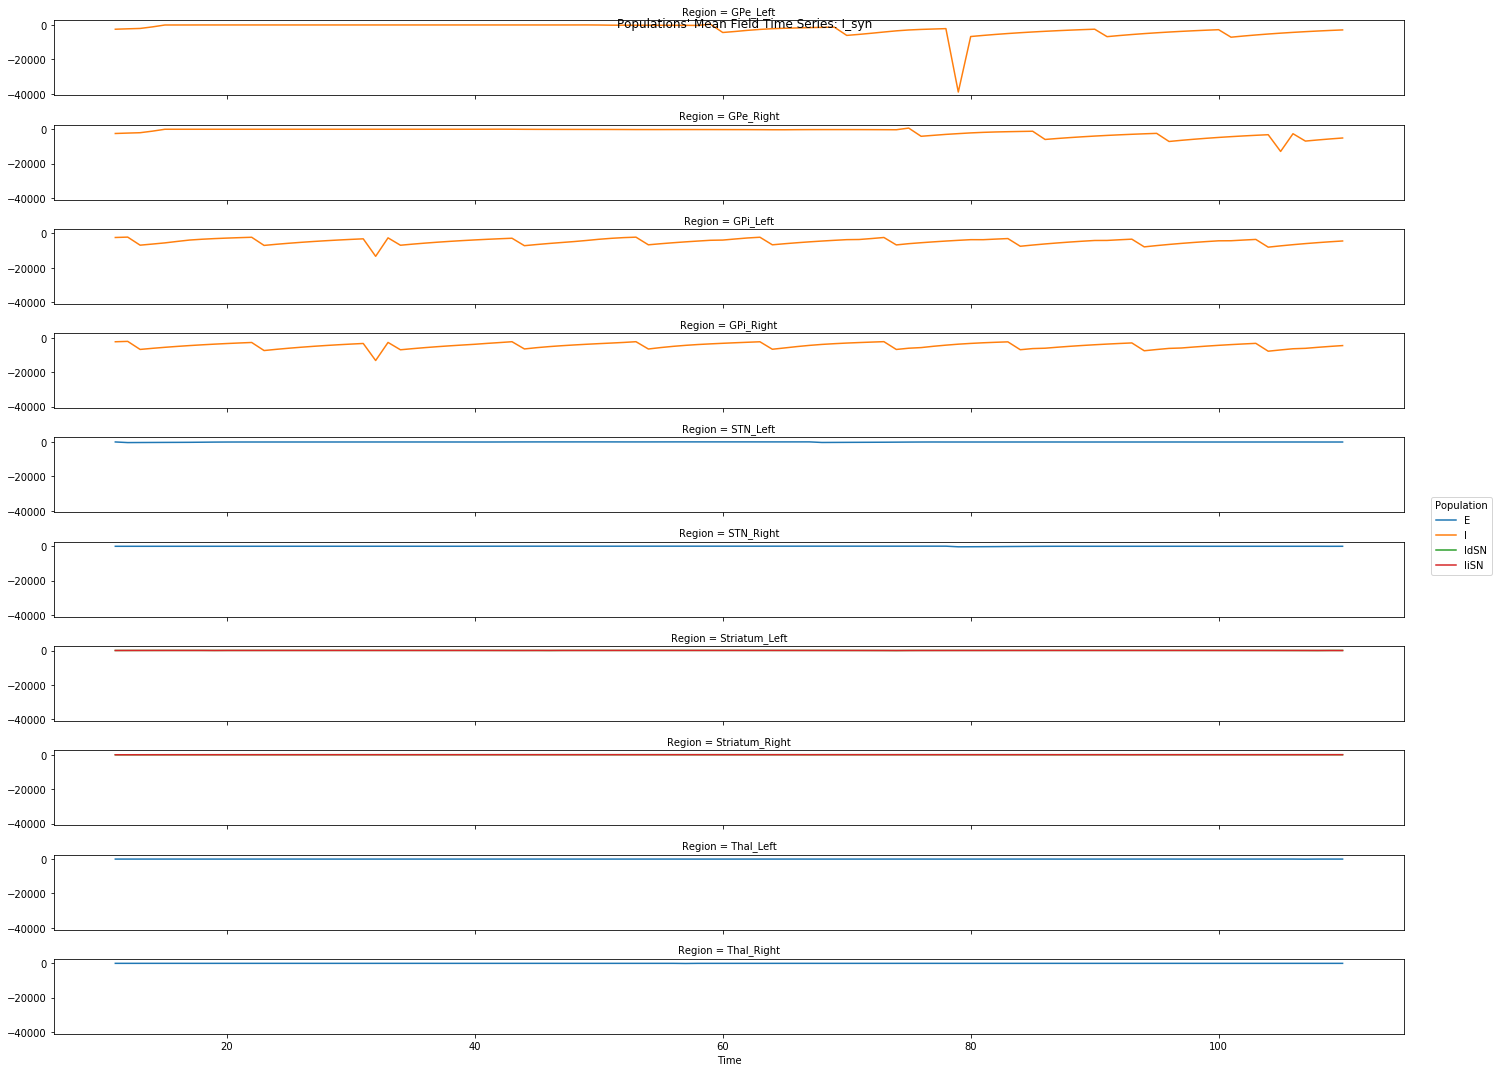

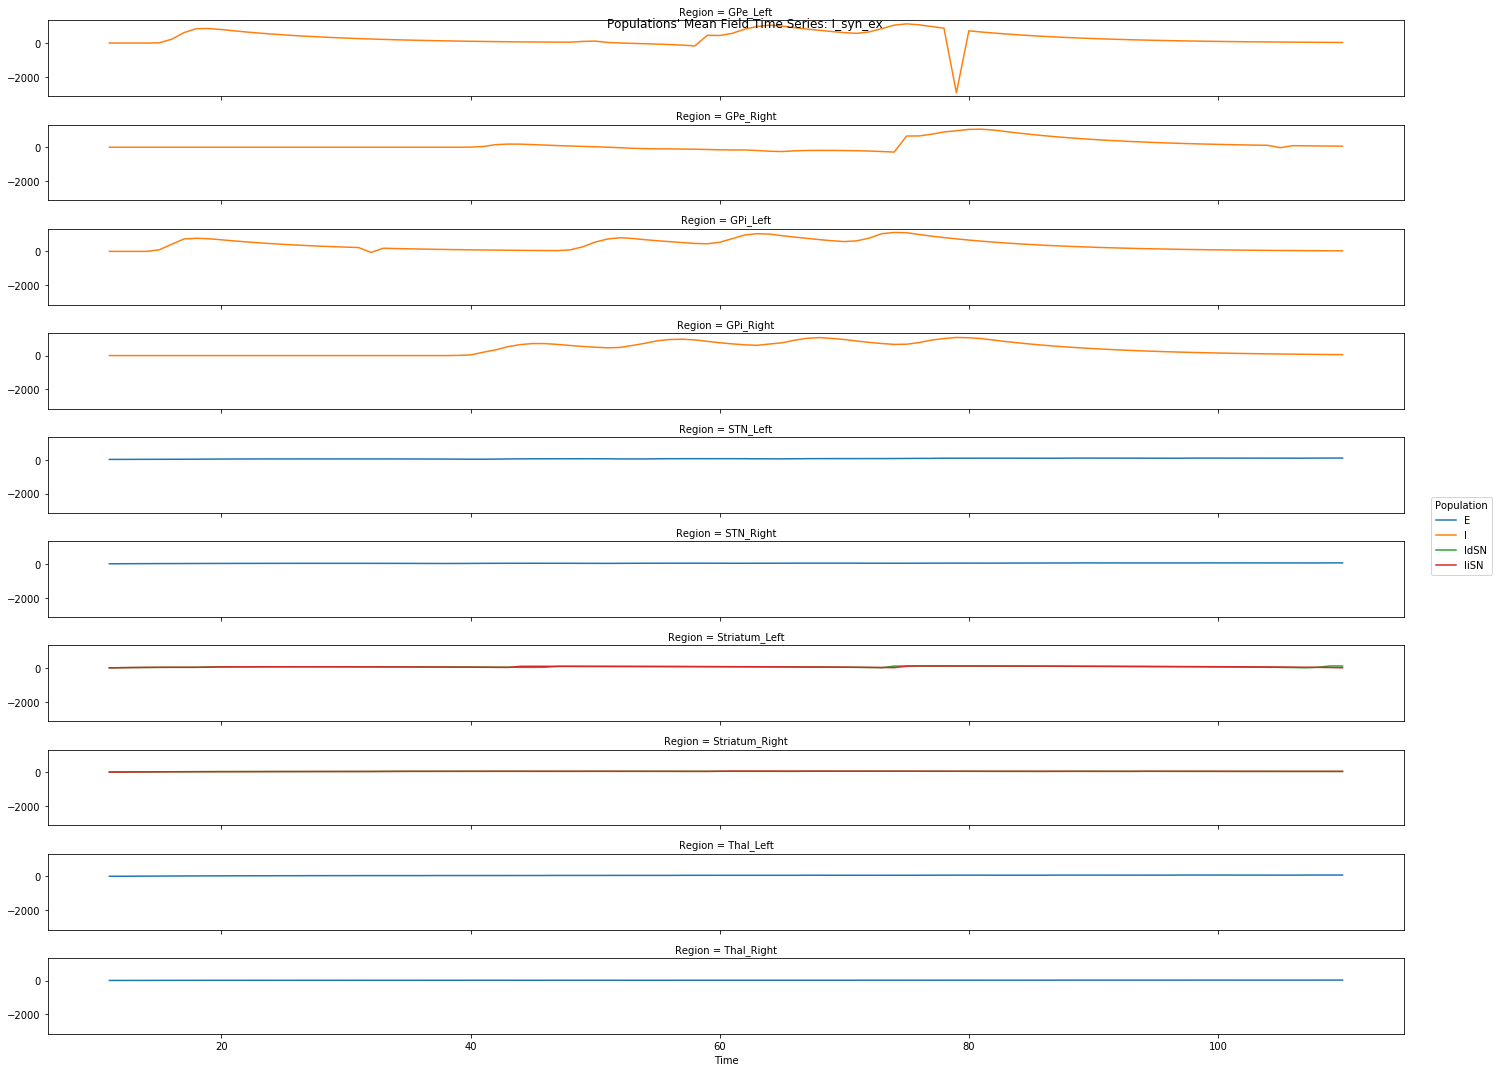

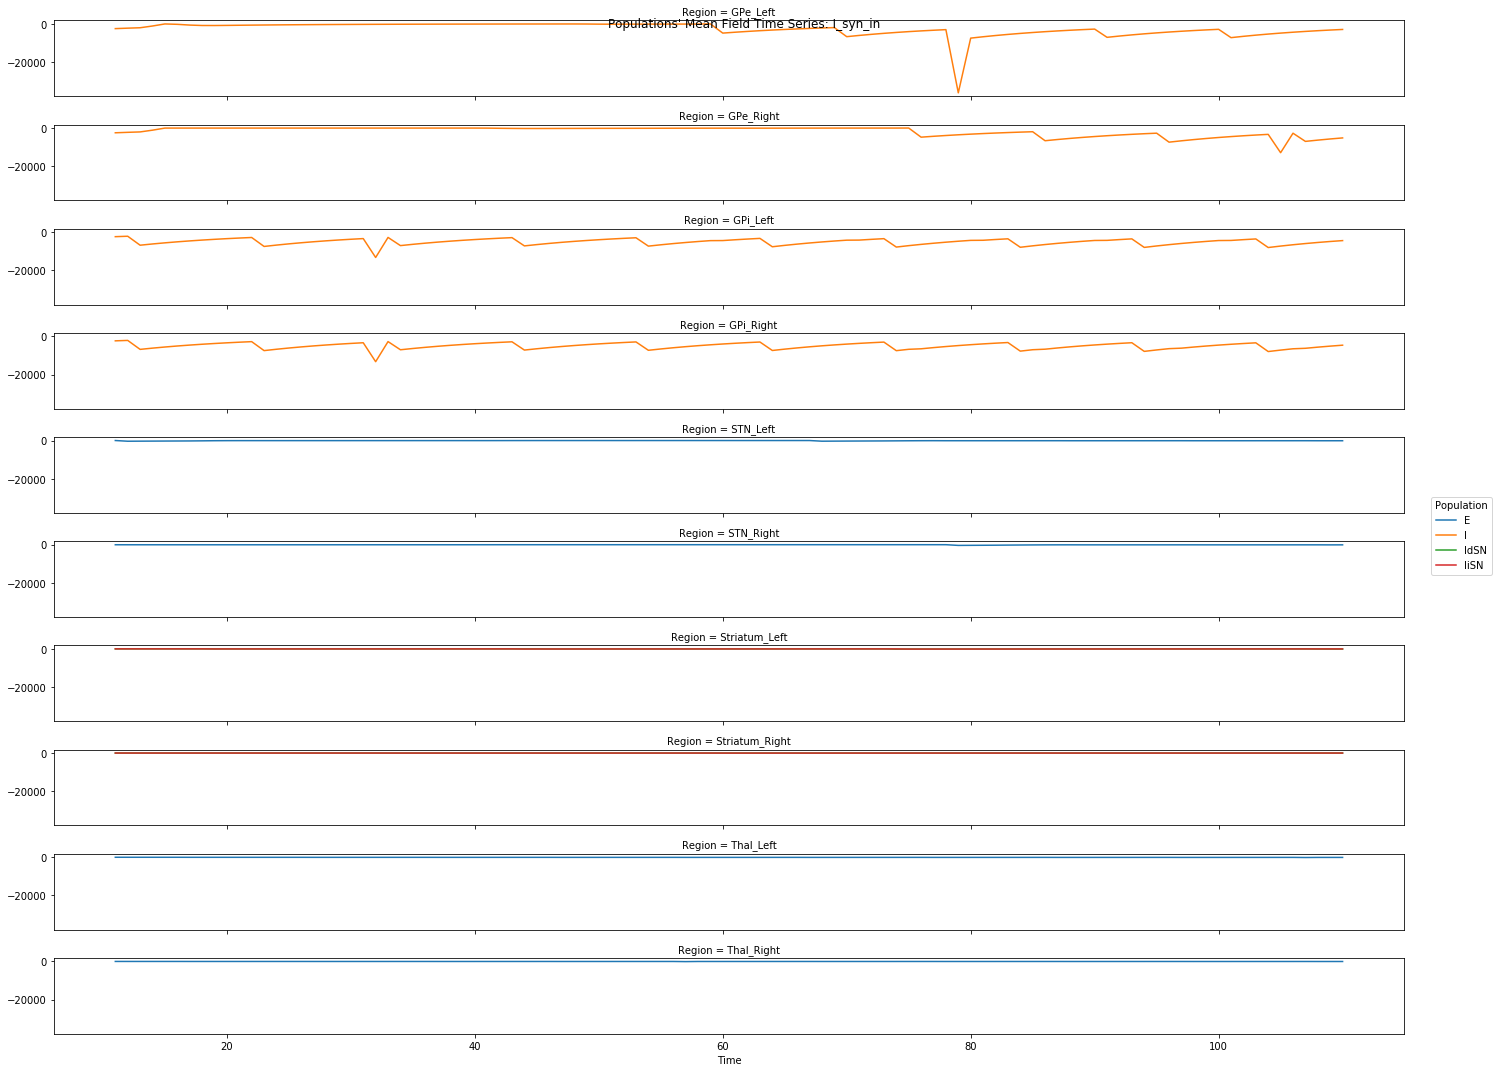

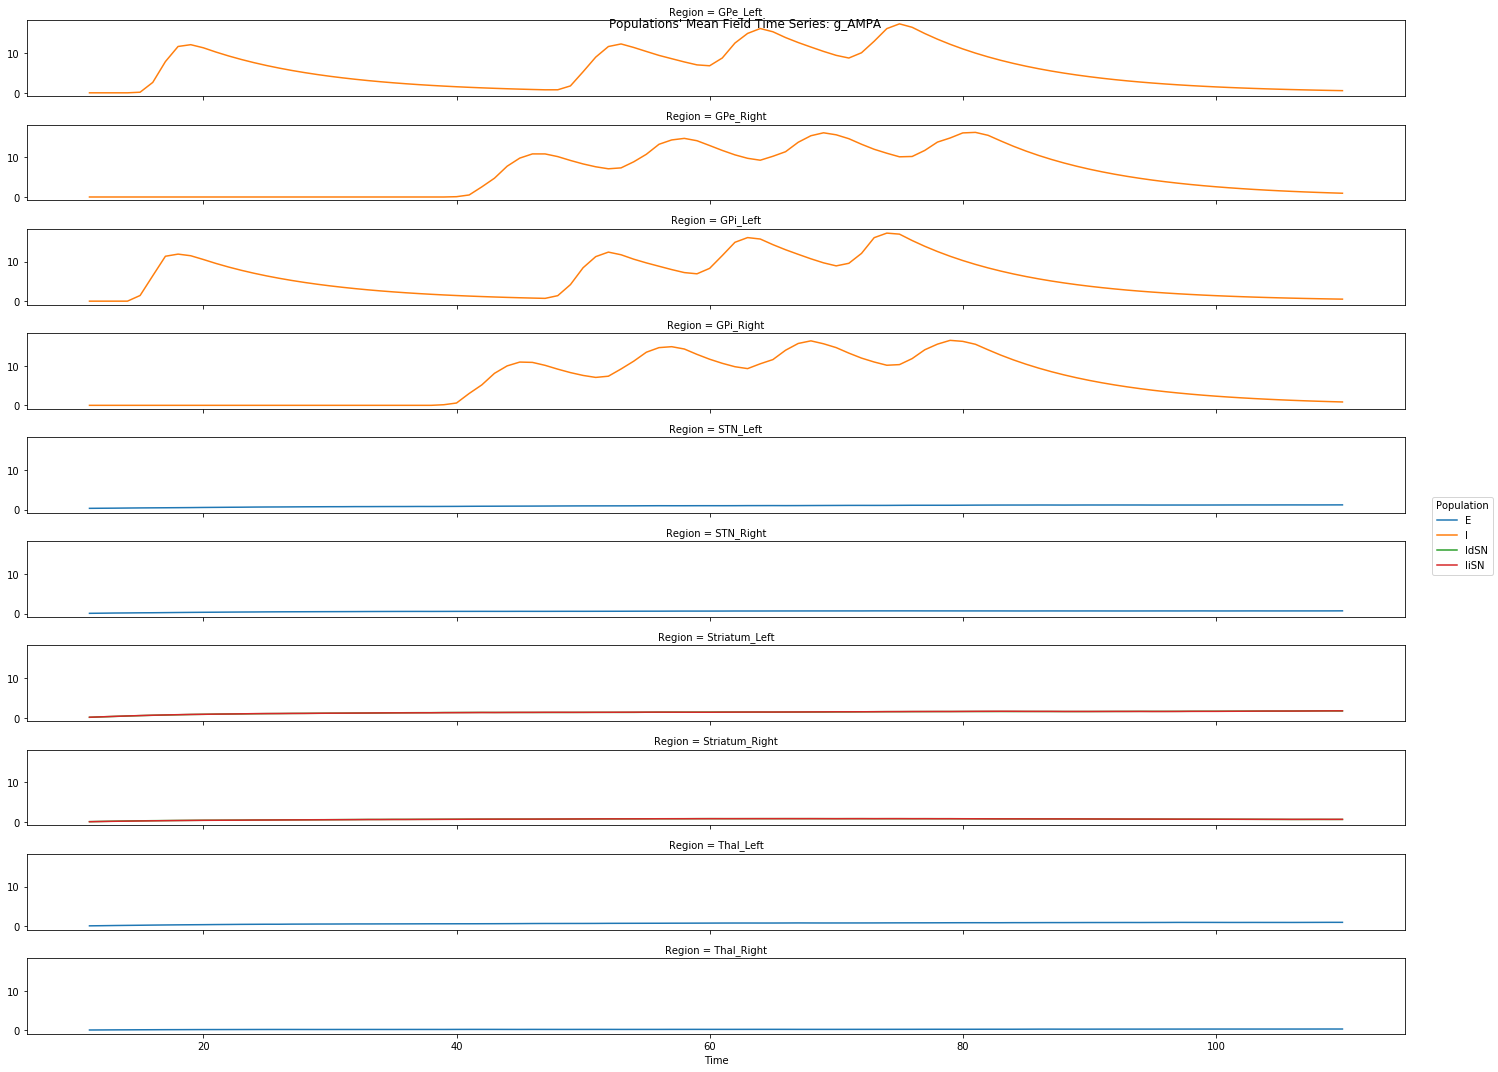

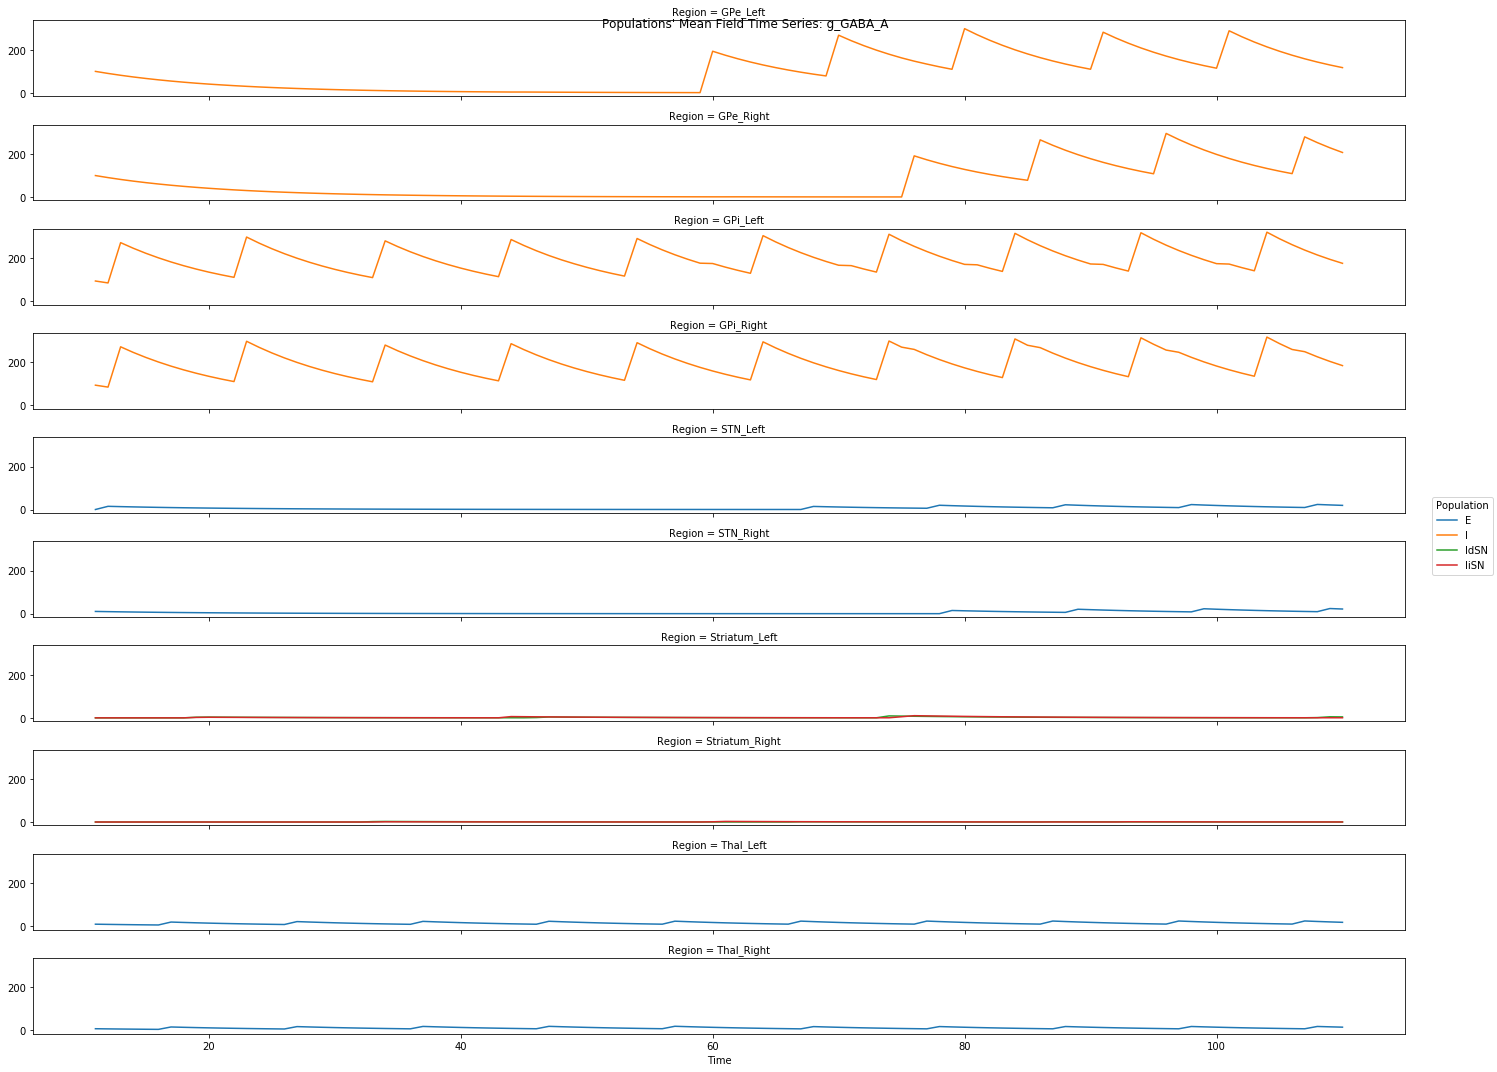

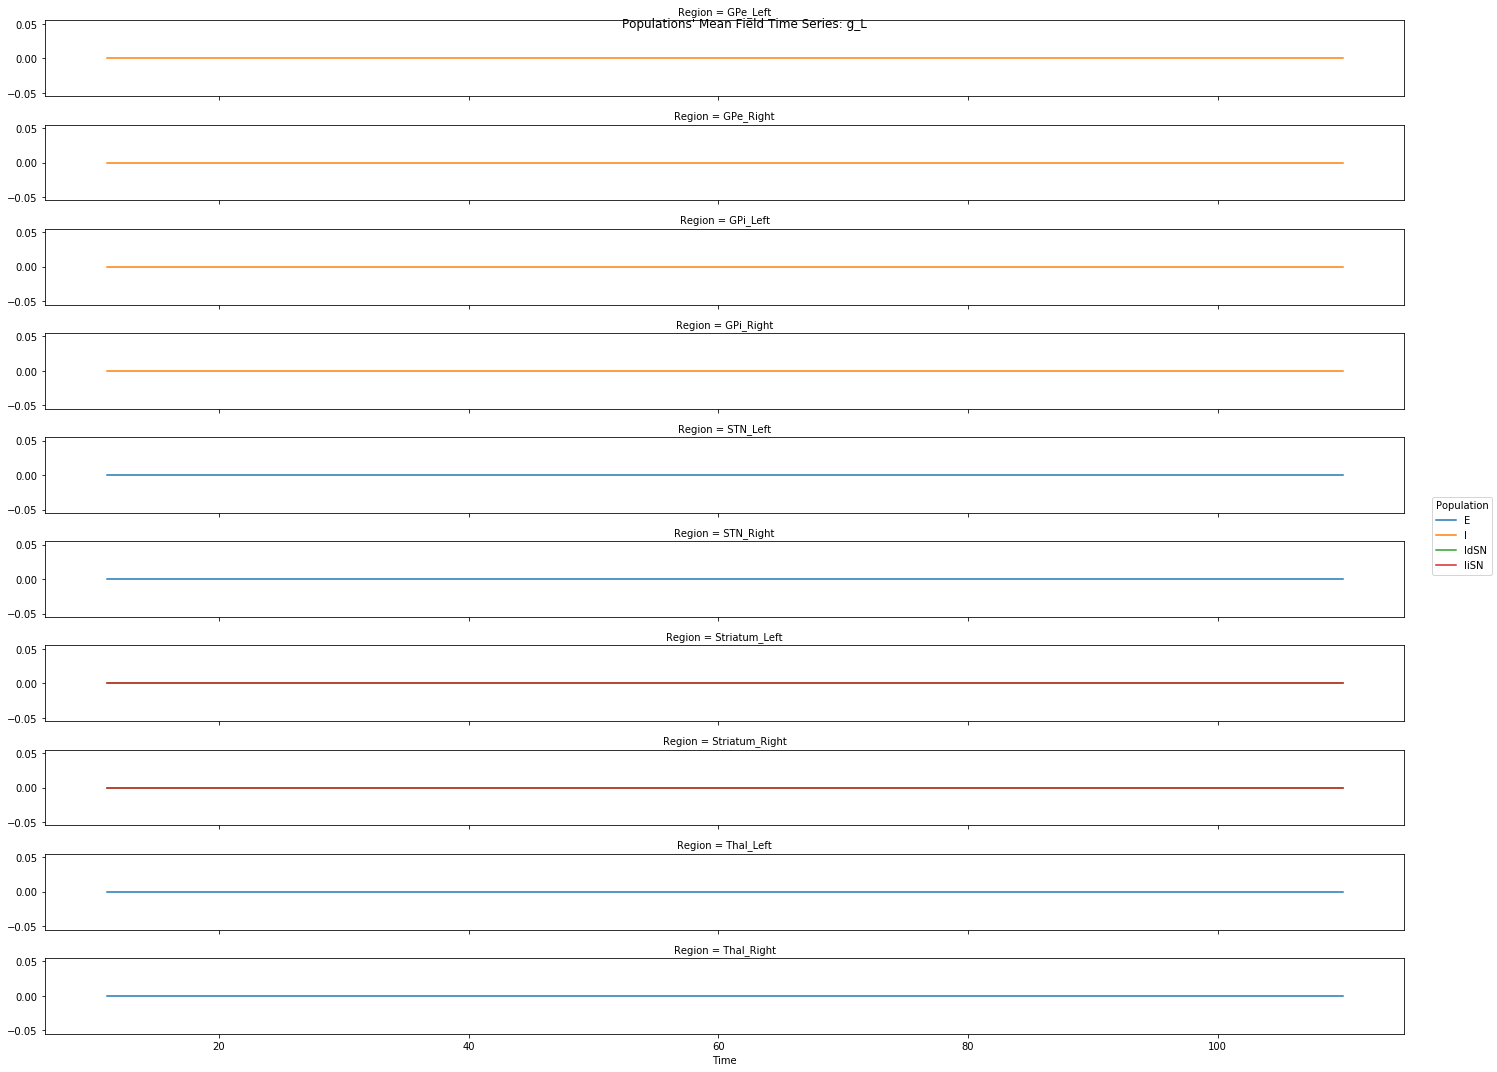

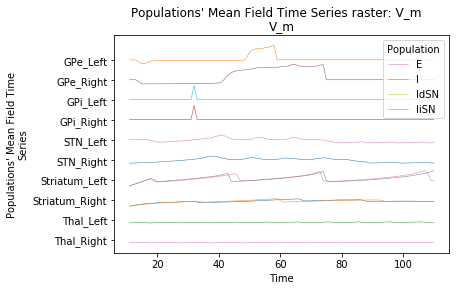

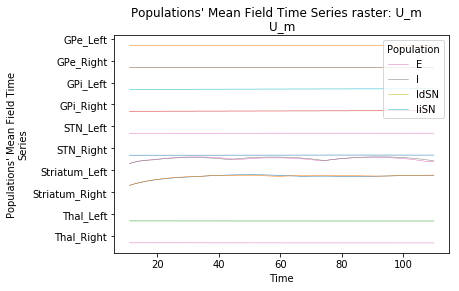

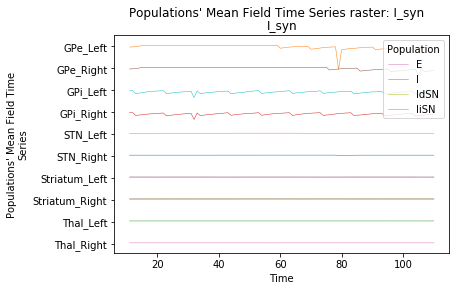

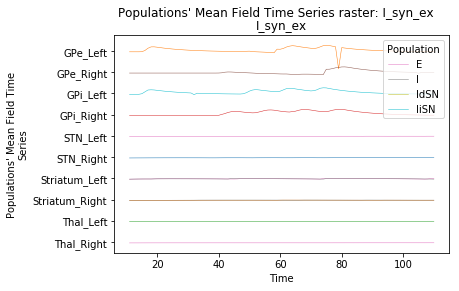

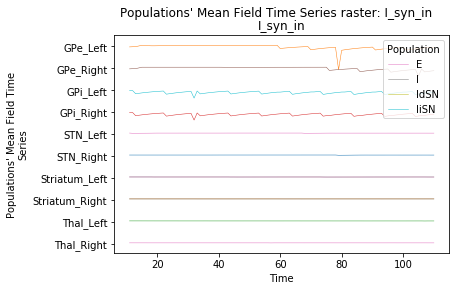

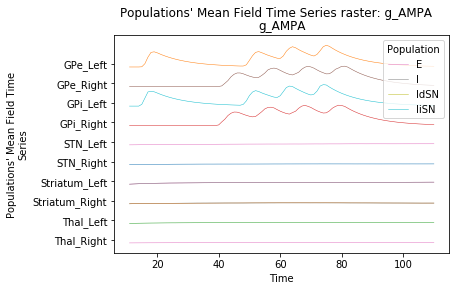

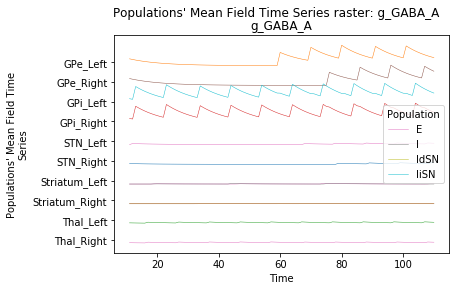

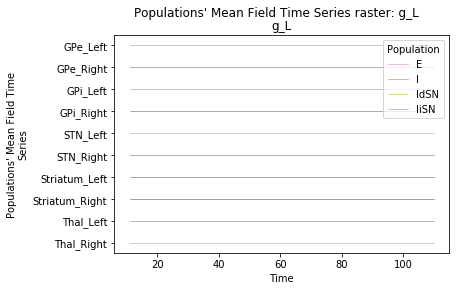

In [24]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
        spikeNet_ts = None
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="-", alpha=1.0, linewidth=0.5)
else:
    mean_field_ts = None

In [25]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [26]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [27]:
# Regions in rows
if spikeNet_ts is not None and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>